In [3]:
import os
import sys
import glob
import datetime

import gzip
import pickle

import numpy as np
import pandas as pd
import scipy 

# skew,kutosis
import padasip as pa
# https://matousc89.github.io/padasip/sources/filters/lms.html 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import biosppy
from biosppy.signals import ecg
from scipy import signal
import pyhrv
import pyhrv.tools as tools
import pyhrv.time_domain as td

import heartpy as hp
from scipy.signal import resample
import mne
from sklearn.decomposition import FastICA

# import matplotlib as mpl
# # %matplotlib
# mpl.use('TkAgg')

In [4]:
# current work directory
path = os.path.abspath(os.getcwd())
print('경로:',path)
# directory file list
# file_list = glob.glob(path+ '/**/*.csv')
#Log 데이터 이름
research_log = '당일 현장조사 기록지(통합).csv'

# research condition constants
DEVICES = ['H10', 'VERITY']
PROTOCOL = ['RESTING', 'MAST']

# time constant(s)
TIME_FORMAT = "%Y%m%d%H%M%S%f"
RESTING_TIME = [420]
MAST_TIME_TABLE = [300, 90, 45, 60, 60, 60, 90, 90, 45, 60]

# protocol constant
# REST = 1, COLD = 2, CACULATE = 3, EMPTY = 0 
MAST_PROTOCOL = [1,2,3,2,3,2,3,2,3,2]
MAST_PROTOCOL_NAME = {0:'EMPTY', 1:'BASELINE', 2: 'HIT', 3:'MA'}
# MAST_PROTOCOL = ['REST','COLD','CACUL','COLD','CACUL','COLD','CACUL','COLD','CACUL','COLD']
# MAST_PROTOCOL = [['REST'],['COLD'],['CACUL'],['COLD'],['CACUL'],['COLD'],['CACUL'],['COLD'],['CACUL'],['COLD']]

# devices constant
# 데이터 시간, 인덱스, ppg 센서 3개, ambient 센서, 수동 입력 marker
VERITY_COL = ['time', 'idx', 'ppg0', 'ppg1', 'ppg2', 'ambient', 'marker', 'proc']
VERITY_FS = 55
# 심박 ecg 센서
H10_COL = ['time', 'idx', 'sensor', 'marker', 'proc']
H10_FS = 130

# time interval caculation을 위한 
Z_list = [0]


# analysis instance
fs = VERITY_FS
#cutoff Wn
# cutoff = [fs*0.03,fs/2*0.97]
cutoff = [1.5,3.5]
ts = 1/ fs
Nyq = fs / 2
# 파라미터 계수 N차 - 늘어나면 늘어날 수록 성능은 올라가겠지만 느려지겠지 y= ax1+bx2+cx3+nxN
order = 2

# filter
sos = signal.butter(order, cutoff, btype='bandpass', output = 'sos', fs = fs) #butterworth bandpass 

경로: /home/pilab/workspace/Stress_sensor_data_processing


In [5]:
def file_search(path):
    '''
        Mast, Resting csv 파일 찾는 함수
        근데 이거 왜 만듬?
        
        path = 현재 작업 디렉토리 절대 위치
        
        파일 명명 로직:(F)_subject_day_time_sensor
    '''
    try:
        filenames = os.listdir(path)
        for filename in filenames:
            full_filename = os.path.join(path, filename)
            if filename == 'Mast':
                # mast_path = full_filename
                file_list_mast = sorted([f for f in os.listdir(full_filename) if f.startswith('(M)')])
            elif filename == 'Resting':
                # resting_path = full_filename
                file_list_resting = sorted([f for f in os.listdir(full_filename) if f.startswith('(H)')])
            else:
                pass 
        # return file_list_mast, file_list_resting, resting_path, mast_path
        return file_list_mast, file_list_resting
    
    except PermissionError:
        print('file search fail')
        pass
    
# file_list_mast, file_list_resting, resting_path, mast_path = file_search(path)
file_list_mast, file_list_resting = file_search(path)
# file_search(path)

In [17]:
def device_listing(file_list):
    '''
        기기 별 csv 파일 찾는 함수
        기기 별로 찾아야 할지, 피험자 별로 찾아야할지 아직 모르겠음, 둘다 해야겠지?
        
        파일 명명 로직:(F)_subject_day_time_sensor
    '''
    # polar sensor data list
    try:
        if file_list[0][:3] == ('(H)'):
            print('Resting data')
        elif file_list[0][:3] == ('(M)'):
            print('Mast data')
            
        file_list_h10 = sorted([f for f in file_list if f.endswith('H10.csv')])
        file_list_verity = sorted([f for f in file_list if f.endswith('Verity.csv')])
        print('Got list')
    except:
        print('wrong list or files')

    return {'h10':file_list_h10, 'verity': file_list_verity}
    

resting_device_dict = device_listing(file_list_resting)
mast_device_dict = device_listing(file_list_mast)

Resting data
Got list
Mast data
Got list


In [18]:
def id_listing():
    return
# print('*** Rest h10 데이터:',rest_file_list_h10)
print('h10 데이터 개수',len(mast_device_dict['h10']),'개')
# print('*** Rest verity 데이터:',rest_file_list_verity)
print('verity 데이터 개수',len(mast_device_dict['verity']),'개')

# 파일 별  분석하려고 대충 보고 있는 for loop
if len(mast_device_dict['h10']) == len(mast_device_dict['verity']):
    print('Number of Data equl')
#     i = 1
#     for h10, verity in zip(rest_file_list_h10, rest_file_list_verity):
        
#         print()
#         print(f'{i}-1:',h10)
#         print('ID:',h10[3:6])
#         print('Date:',h10[7:22])

#         print(f'{i}-2:',verity)
#         print('ID:',verity[3:6])
#         print('Date:',verity[7:22])
        
#         i += 1
else:
    print('expected data missing')

h10 데이터 개수 40 개
verity 데이터 개수 40 개
Number of Data equl


In [19]:
def date_data_load(device_file_dict = {}, date = '20230101', task = 'resting'):
    date_h10_dict = {}
    date_verity_dict = {}
    if task == 'resting':
        task_path = path + '/Resting/'
    else:
        task_path = path + '/Mast/'
    
    for i in device_file_dict:
        if i == 'h10':
            date_h10 = [data for data in device_file_dict[i] if date in data]
        elif i == 'verity':
            date_verity = [data for data in device_file_dict[i] if date in data]
        else:
            print('someting is wrong')
            
    print('Data Loading...')
    for df in  date_h10:
        date_h10_dict[df] = pd.read_csv(task_path + df, names = H10_COL)
    for df in  date_verity:
        date_verity_dict[df] = pd.read_csv(task_path + df, names = VERITY_COL)
    print('Data Load complete')

    print(f'{date} - H10 데이터: {len(date_h10_dict)} 개')
    print(f'{date} - Verity 데이터: {len(date_verity_dict)} 개')
            
    return {'h10_dict': date_h10_dict, 'verity_dict': date_verity_dict}


# rest_h10_dict, rest_verity_dict =  date_listing(rest_file_list_h10, rest_file_list_verity)
# dir(rest_file_list_h10)
mast_date_dict_list = date_data_load(mast_device_dict, '20230514', 'mast')

Data Loading...
Data Load complete
20230514 - H10 데이터: 19 개
20230514 - Verity 데이터: 19 개


In [20]:
def outlier_drop(data, method = 'iqr', threshold = 3):
    if method == 'iqr':
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = (q3 - q1)*1.5
        low = q1 - iqr
        high = q3 + iqr
        outlier_index = data[(data<low) | (data>high)].index
        data.drop(outlier_index, axis = 0, inplace = True)

    elif method == 'zscore':
        mean = np.mean(data)
        std = np.std(data)
        z_scores = [(x - mean) / std for x in data]  # 각 데이터의 Z-점수 계산
        outliers = [data[i] for i, z in enumerate(z_scores) if abs(z) > threshold] 
    
    elif method == 'std':
        low = data.mean() - (threshold*data.std())
        high = data.mean() + (threshold*data.std())
        outlier_index = data[(data<low) | (data>high)].index
        data.drop(outlier_index, axis = 0, inplace = True)

    return data


def reject_outliers(sr, iq_range=0.5):
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    return sr[ (sr - median).abs() <= iqr]

In [21]:
def moving_average_nomalization(data = pd.DataFrame() , value = '', window_size = 3):

    moving_average_filter = pd.Series(data[value].rolling(window_size).mean())
    filtered_df = data.assign(filtered_value= moving_average_filter )
    print(filtered_df)

    return filtered_df

In [22]:
print(path)
'''
'CID', = cid
'워치번호', = wid
'심박 실시일자', = resting_date
'조사실(스트랩 넘버)예. 220호(2번)', = resting_room
'키', - height
'몸무게', - weight
'신체/심박 특이사항 (조사 컨디션 상세하게 작성)', = p_note
'MAST실시일자(23-05-06 10:00)', = mast_date
'조사실(스트랩 넘버)예. 220호(4번)', = mast_room
'마지막 음식 섭취 시간', = ate_time
'M0 타액 채취 시간', = m0
'T(실험 시작 시간)##:##:00초 기준', = t
'M1 타액 채취 시간', = m1
'M2 타액 채취 시간', = m2
'MAST 특이사항', = m_note
'M3 타액 채취 시간', = m3
'M4 타액 채취 시간', = m4
'M5 타액 채취 시간', = m5
'M6 타액 채취 시간', = m6
'채취실 특이사항' = etc
'''
tmp = pd.DataFrame(columns = ['id', 'mast_start_time'])
protocol_cols = ['id', 'wid', 'resting_date', 'resting_room', 'eat_note', 'height', 'weight',
       'p_note', 'mast_date', 'mast_room', 'ate_time', 'M0', 't', 'M1', 'M2', 'm_note', 'M3', 'M4', 'M5', 'M6', 'etc']
protocol_data = pd.read_csv(path + '/' + research_log, header = 2, names = protocol_cols, index_col= False)
for i, v in protocol_data.iterrows():
    if type(v.mast_date) == str:
        t_time = datetime.datetime.strptime(v.mast_date +'-'+ v.t, '%y-%m-%d-%H:%M')
        t_start_time = t_time - datetime.timedelta(minutes = 5)
        row = pd.DataFrame({'id':[v.id], 'mast_start_time':[t_start_time]})
    else:
        t_start_time = None
        pass
    
    tmp = pd.concat([tmp, row]).drop_duplicates().reset_index(drop=True)
    
protocol_data = pd.merge(protocol_data,tmp, on = 'id')
task_time = protocol_data[['id','t', 'mast_start_time']]
print(task_time)

/home/pilab/workspace/Stress_sensor_data_processing
    id      t     mast_start_time
0    1   9:48 2023-05-07 09:43:00
1    2  10:44 2023-05-07 10:39:00
2    3   9:12 2023-05-07 09:07:00
3    4   9:44 2023-05-07 09:39:00
4    5  11:49 2023-05-07 11:44:00
5    6  11:16 2023-05-07 11:11:00
6    7  11:15 2023-05-07 11:10:00
7    8  11:45 2023-05-07 11:40:00
8    9   9:58 2023-05-07 09:53:00
9   10  10:44 2023-05-07 10:39:00
10  11  12:15 2023-05-07 12:10:00
11  12   9:40 2023-05-07 09:35:00
12  13  11:45 2023-05-07 11:40:00
13  14   9:55 2023-05-07 09:50:00
14  16   9:10 2023-05-07 09:05:00
15  17  11:14 2023-05-07 11:09:00
16  18  10:21 2023-05-07 10:16:00
17  19  10:17 2023-05-07 10:12:00
18  20  12:37 2023-05-07 12:32:00
19  21   9:06 2023-05-14 09:01:00
20  22   9:05 2023-05-14 09:00:00
21  23  11:35 2023-05-14 11:30:00
22  24  10:11 2023-05-14 10:06:00
23  25   9:40 2023-05-14 09:35:00
24  26   9:40 2023-05-14 09:35:00
25  27   9:07 2023-05-14 09:02:00
26  28  10:14 2023-05-14 10:09

In [30]:
# Data check 1
for i in mast_date_dict_list:
    try:
        with gzip.open(f'./pkl/{i}_mast.pickle','rb') as f:
            df = pickle.load(f)
    except:
        pass
    if len(df) == 0 :
        df = pd.DataFrame(columns = ['id', 'date', 'protocol', 'device', 'start', 'end', 'total', 'avg', 'fs'])
    # print(df)

    for j in mast_date_dict_list[i]:
        # print(j)
        if j.endswith('H10.csv'):
            # print('H10 모양 :', mast_date_dict_list[i][j].shape)
            h10_rows, h10_columns = mast_date_dict_list[i][j].shape
            if h10_columns == 4:
                # print('H10 Data columns length is correct')
                pass
            else:
                break
                print('H10 Data columns length is Not correct')
        elif j.endswith('Verity.csv'):
            # print('verity 모양 :', mast_date_dict_list[i][j].shape)
            verity_rows, verity_columns = mast_date_dict_list[i][j].shape
            if verity_columns == 7:
                # print('Verity sensor Data columns length is correct')
                pass
            else:
                break
                print('Verity sensor Data columns length is Not correct')
    print(i + ' OK!')
    
    for j in mast_date_dict_list[i]:
        print(j)
        # df time을 datetime으로 캐스팅
        mast_date_dict_list[i][j]['times'] = pd.to_datetime(mast_date_dict_list[i][j]['time'], 
                                                               format = TIME_FORMAT)

        # !! 매우 느림, interval을 구하는 부분임 이게 또 어디에 쓰이던가?        
        # mast_date_dict_list[i][j]['interval'] = \
        #     Z_list + [mast_date_dict_list[i][j]['times'].loc[k+1]-mast_date_dict_list[i][j]['times'].loc[k] 
        #               for k in range(len(mast_date_dict_list[i][j])-1)]

        mast_start_time = mast_date_dict_list[i][j].iloc[0][-2]
        mast_end_time = mast_date_dict_list[i][j].iloc[-1][-2]
        mast_total_time = mast_end_time-mast_start_time
        mast_time_resolution = (mast_end_time-mast_start_time)/ len(mast_date_dict_list[i][j])
        # mast_fs = 1/ mast_time_resolution.total_seconds()
        
        print('Time domain window')
        print('시작 시간:',mast_start_time, '종료 시간:',mast_end_time, '총 측정 시간:', mast_total_time)
        
        # if 20 <= abs(mast_total_time.total_seconds()-MAST_TIME_TABLE[0]):
        #     print('Wrong measurement time')

        print('해상도:', mast_time_resolution, 'fs:', mast_fs)

        row = pd.DataFrame({'id':[j[3:6]], 'date':[j[7:22]], 'protocol':[j[1:2]], 'device':[j[23:-4]], 
                        'start':[mast_start_time], 'end':[mast_end_time], 'total':[mast_total_time],
                        'avg':[mast_time_resolution], 
                        # 'fs':[mast_fs]
                        })
        df = pd.concat([df, row]).drop_duplicates().reset_index(drop=True)
        
#         if 'h10' in i:

#             if mast_fs <= 0.07693 and mast_fs >= 0.07692:
#                 # print("Hz correct.")
#                 pass
#             else:
#                 print("Hz Error!!!!")
#         else:
#             print('해상도:', mast_time_resolution, 'fs:', mast_fs)
#             if rest_h10_fs <= 0.018182 and rest_h10_fs >= 18181:
#                 # print("Hz correct.")
#                 pass
#             else:
#                 print("Hz Error!!!!")
        # print('interval data...')
        # print(mast_date_dict_list[i][j]['interval'])
            # time col datatype cast to datetime 

        print('----------------------------------------------------------------------')

    if 'h10' in i:
        mast_h10_dict = mast_date_dict_list[i]
    else:
        mast_verity_dict = mast_date_dict_list[i]
    
    with gzip.open(f'./pkl/{i}_mast.pickle', 'wb') as f:
        pickle.dump(df, f)

h10_dict OK!
(M)021_20230514_085449_H10.csv
Time domain window
시작 시간: 2023-05-14 08:54:49.383285 종료 시간: 2023-05-14 09:21:59.170041 총 측정 시간: 0 days 00:27:09.786756
해상도: 0 days 00:00:00.007698567 fs: 129.90387113535982
----------------------------------------------------------------------
(M)022_20230514_085450_H10.csv
Time domain window
시작 시간: 2023-05-14 08:54:50.966796 종료 시간: 2023-05-14 09:16:40.260694 총 측정 시간: 0 days 00:21:49.293898
해상도: 0 days 00:00:00.007697653 fs: 129.90387113535982
----------------------------------------------------------------------
(M)023_20230514_113519_H10.csv
Time domain window
시작 시간: 2023-05-14 11:35:19.238449 종료 시간: 2023-05-14 11:49:06.450639 총 측정 시간: 0 days 00:13:47.212190
해상도: 0 days 00:00:00.007698147 fs: 129.90387113535982
----------------------------------------------------------------------
(M)024_20230514_100224_H10.csv
Time domain window
시작 시간: 2023-05-14 10:02:24.836792 종료 시간: 2023-05-14 10:24:19.260780 총 측정 시간: 0 days 00:21:54.423988
해상도: 0 days 

In [32]:
with gzip.open(f'./pkl/verity_dict_mast.pickle','rb') as f:
    df = pickle.load(f)
df['id'] = pd.to_numeric(df['id'], downcast = 'integer')
df = pd.merge(df, task_time, how = 'outer', on = 'id')
# df = pd.concat([df, task_time], axis = 1)
print(df)

     id             date protocol  device                      start   
0     1  20230429_091641        H     H10 2023-04-29 09:16:41.348517  \
1     1  20230507_093641        M     H10 2023-05-07 09:36:41.616168   
2     1  20230507_094057        M     H10 2023-05-07 09:40:57.469639   
3     1  20230507_093641        M  Verity 2023-05-07 09:36:41.622437   
4     1  20230507_094057        M  Verity 2023-05-07 09:40:57.475944   
..   ..              ...      ...     ...                        ...   
110  39  20230506_122927        H     H10 2023-05-06 12:29:27.980722   
111  39  20230514_114313        M  Verity 2023-05-14 11:43:13.389437   
112  39  20230514_114313        M  Verity                        NaT   
113  38  20230514_113625        M  Verity 2023-05-14 11:36:25.852871   
114  38  20230514_113625        M  Verity                        NaT   

                           end                  total   
0   2023-04-29 09:23:42.218059 0 days 00:07:00.869542  \
1   2023-05-07 09:40:

In [33]:
# pd.set_option('display.max_row', None)
# pd.set_option('display.max_columns', None)
# print(mast_h10['interval'])

In [34]:
# index to time 사실 필요없고 오히려 방해됨... 수정 필수
# mast_h10 = mast_h10.set_index('times')
# mast_verity = mast_verity.set_index('times')
# sns.set(rc={'figure.figsize':(11, 4)})

(M)021_20230514_085449_Verity.csv


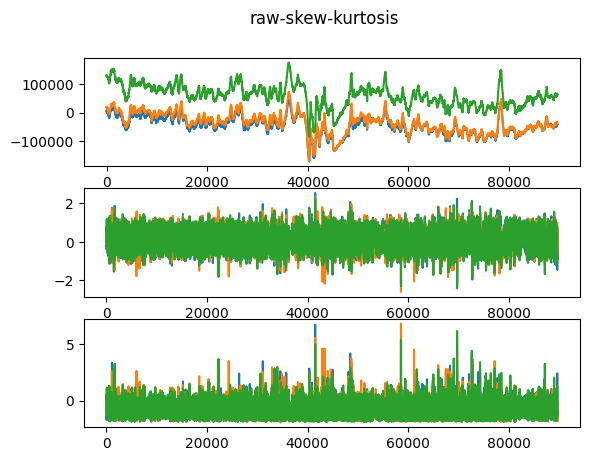

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)022_20230514_085450_Verity.csv


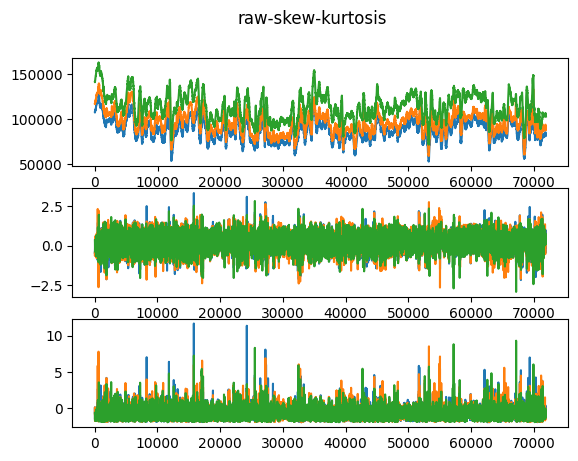

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)023_20230514_113519_Verity.csv


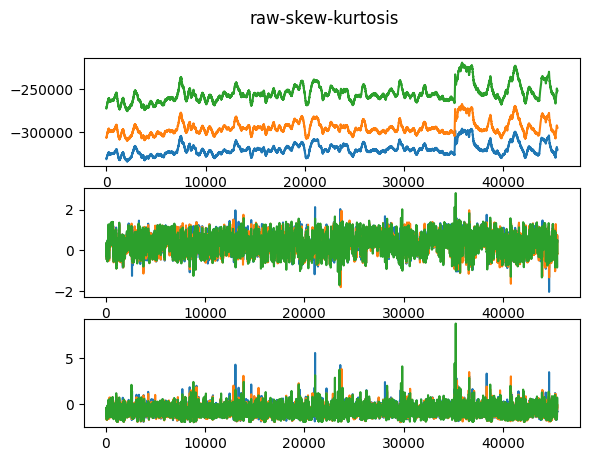

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)024_20230514_100224_Verity.csv


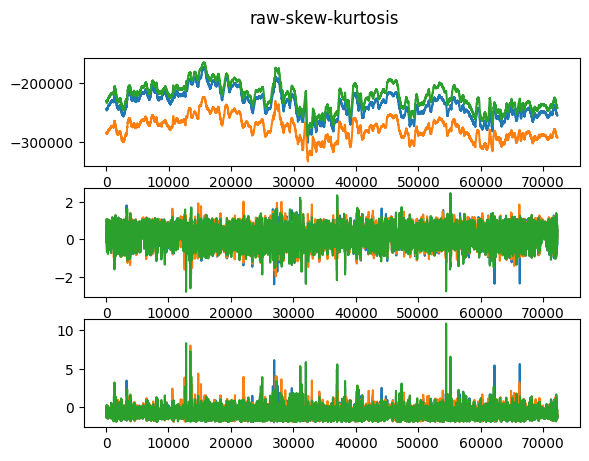

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)025_20230514_092935_Verity.csv


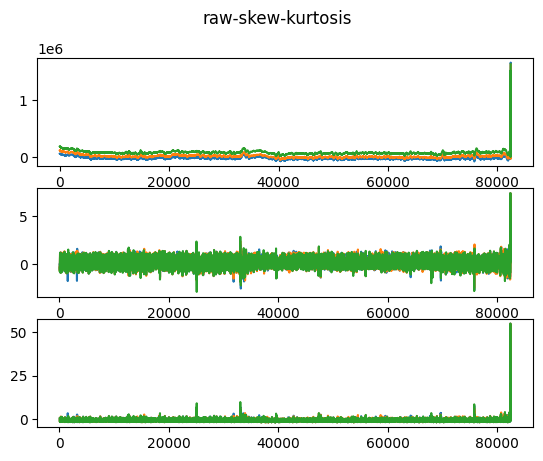

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)026_20230514_093003_Verity.csv


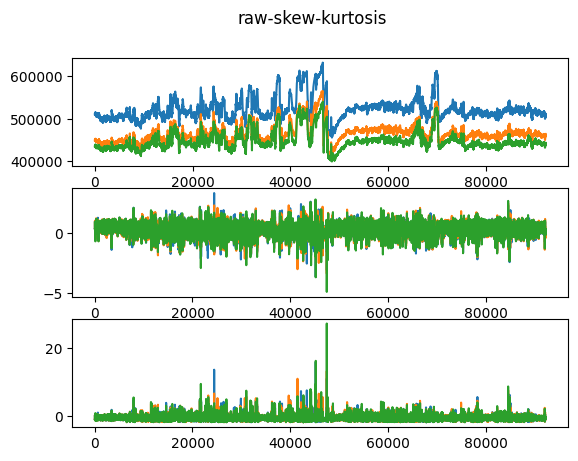

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)027_20230514_085612_Verity.csv


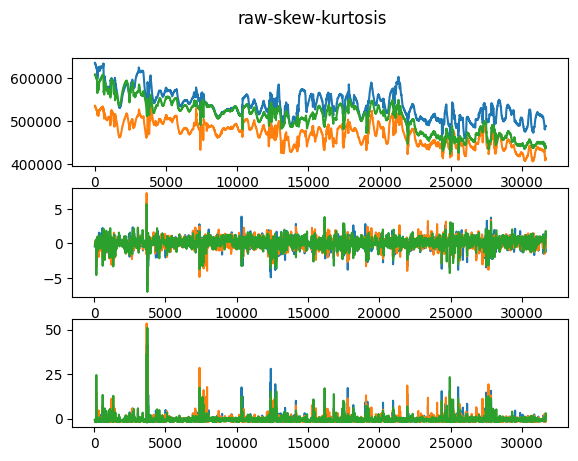

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)028_20230514_100734_Verity.csv


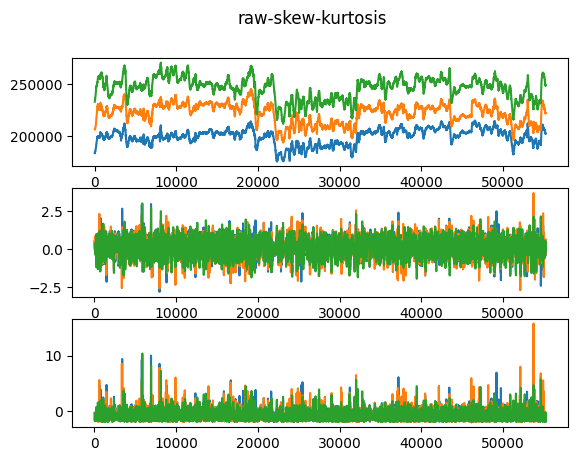

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)029_20230514_093104_Verity.csv


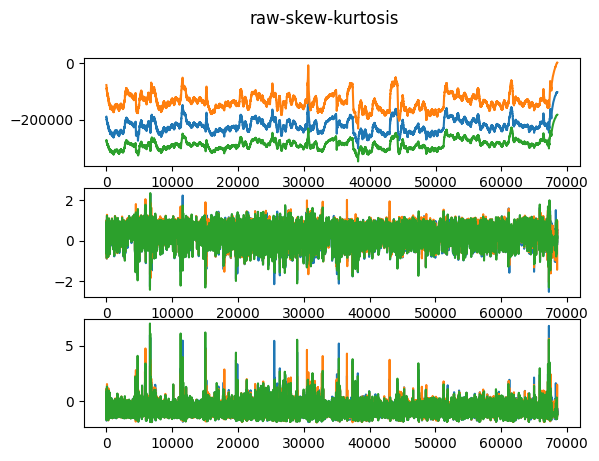

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)030_20230514_123122_Verity.csv


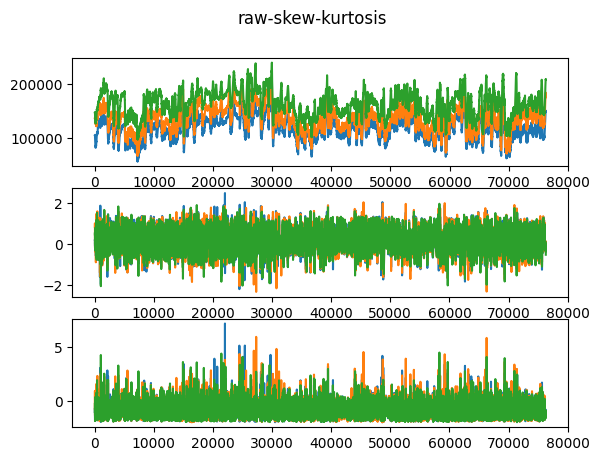

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)031_20230514_105514_Verity.csv


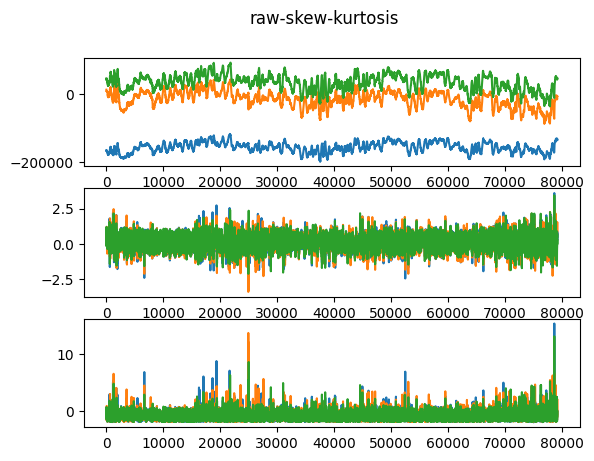

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)032_20230514_105549_Verity.csv


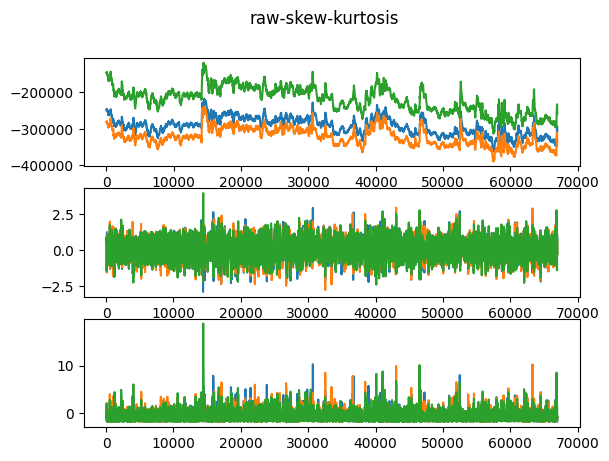

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)033_20230514_100159_Verity.csv


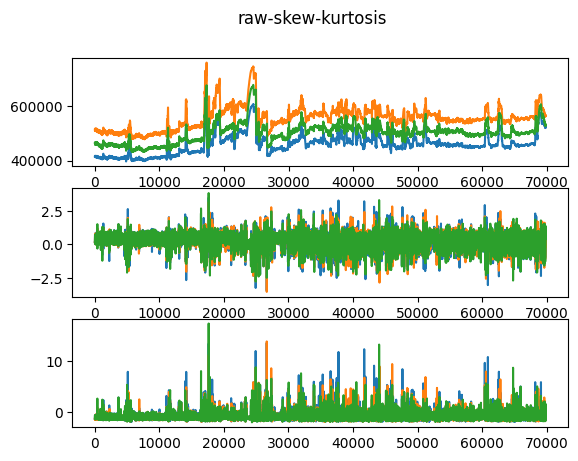

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)034_20230514_122503_Verity.csv


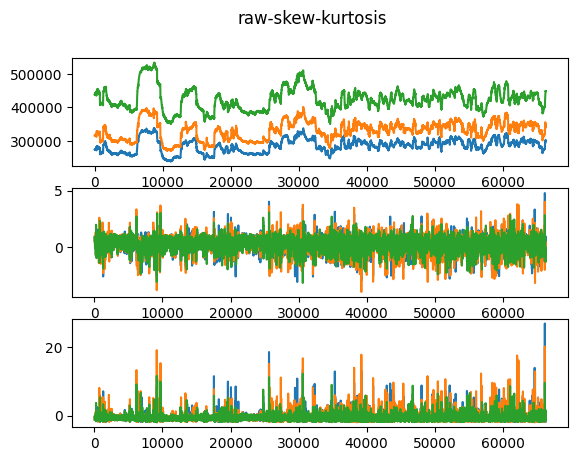

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)035_20230514_115902_Verity.csv


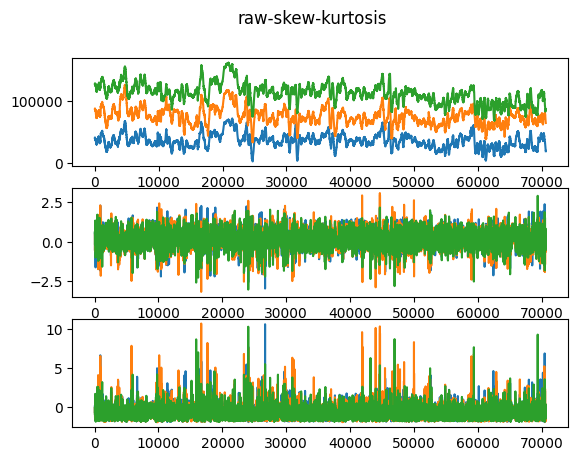

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)036_20230514_105506_Verity.csv


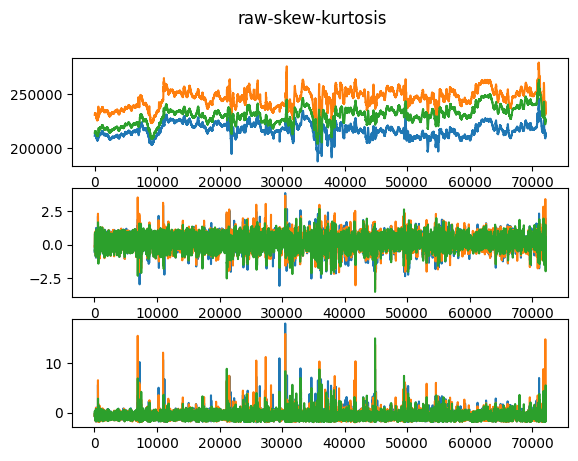

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)037_20230514_123409_Verity.csv


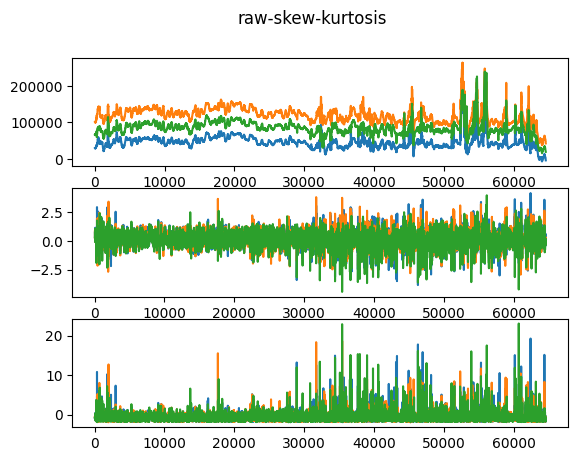

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)038_20230514_113625_Verity.csv


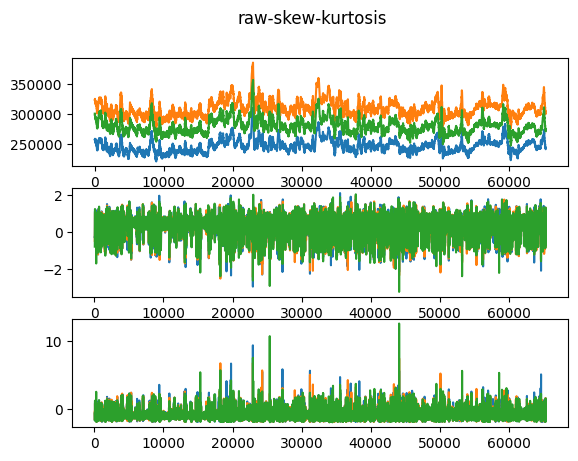

<Figure size 1200x800 with 0 Axes>

Value is nan
(M)039_20230514_114313_Verity.csv


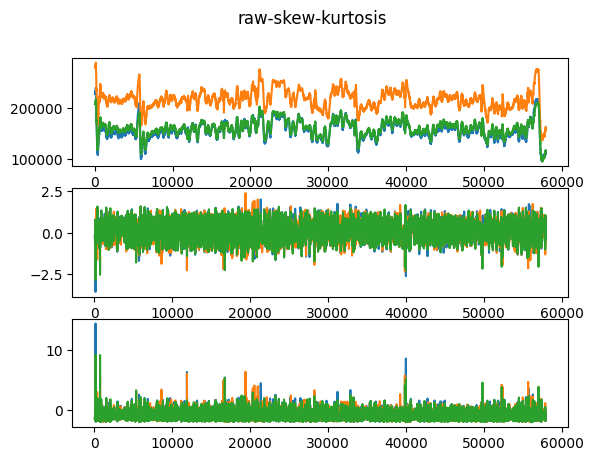

<Figure size 1200x800 with 0 Axes>

Value is nan


In [35]:
for i in mast_verity_dict:
    print(i)

    fig, axs = plt.subplots(3)
    fig.suptitle('raw-skew-kurtosis')
    plt.figure(figsize=(15, 10), dpi=80)

    axs[1].plot(pd.DataFrame(mast_verity_dict[i][['ppg0', 'ppg1', 'ppg2']]).rolling(window = 55).skew())
    axs[2].plot(pd.DataFrame(mast_verity_dict[i][['ppg0', 'ppg1', 'ppg2']]).rolling(window = 55).kurt())
    axs[0].plot(mast_verity_dict[i][['ppg0', 'ppg1', 'ppg2']])
    plt.show()
    
    for p in mast_verity_dict[i]['proc'].unique():
        if np.isnan(p):
            print('Value is nan')
            pass
        else:
            print(p)
            print('프로토콜:', p, MAST_PROTOCOL_NAME[p])
               
            signals = mast_verity_dict[i][mast_verity_dict[i]['proc'] == p][['ppg0', 'ppg1', 'ppg2']]
            ambient = mast_verity_dict[i][mast_verity_dict[i]['proc'] == p]['ambient']    

            try:
                for j in signals:
                    print(j, '- skew', scipy.stats.skew(signals[j]))
                    print(j, '- kutosis', scipy.stats.kurtosis(signals[j]))
                    fig, axs = plt.subplots(3)
                    fig.suptitle('raw-skew-kurtosis')
                    plt.figure(figsize=(15, 10), dpi=80)

                    axs[1].plot(pd.DataFrame(signals[j]).rolling(window = 55).skew())
                    axs[2].plot(pd.DataFrame(signals[j]).rolling(window = 55).kurt())
                    axs[0].plot(signals[j])
                    plt.show()
            except:
                print(' VALUE ERROR')
                print('-'*30)
                pass
        

(M)021_20230514_085449_Verity.csv
    id             date protocol  device                      start   
59  21  20230506_091434        H     H10 2023-05-06 09:14:34.521366  \
60  21  20230514_085449        M  Verity 2023-05-14 08:54:49.389594   
61  21  20230514_085449        M  Verity                        NaT   

                          end                  total   
59 2023-05-06 09:21:48.325326 0 days 00:07:13.803960  \
60 2023-05-14 09:21:59.307784 0 days 00:27:09.918190   
61                        NaT                    NaT   

                         avg          fs     t     mast_start_time  
59 0 days 00:00:00.007697564  129.920748  9:06 2023-05-14 09:01:00  
60 0 days 00:00:00.018189427   54.978284  9:06 2023-05-14 09:01:00  
61                       NaT         NaN  9:06 2023-05-14 09:01:00  
전체길이: 89608
시작 시간: 2023-05-14 09:01:00
시작 인덱스 값: 20372
기간 리스트: [Timestamp('2023-05-14 09:01:00'), Timestamp('2023-05-14 09:06:00'), Timestamp('2023-05-14 09:07:30'), Timestamp('202

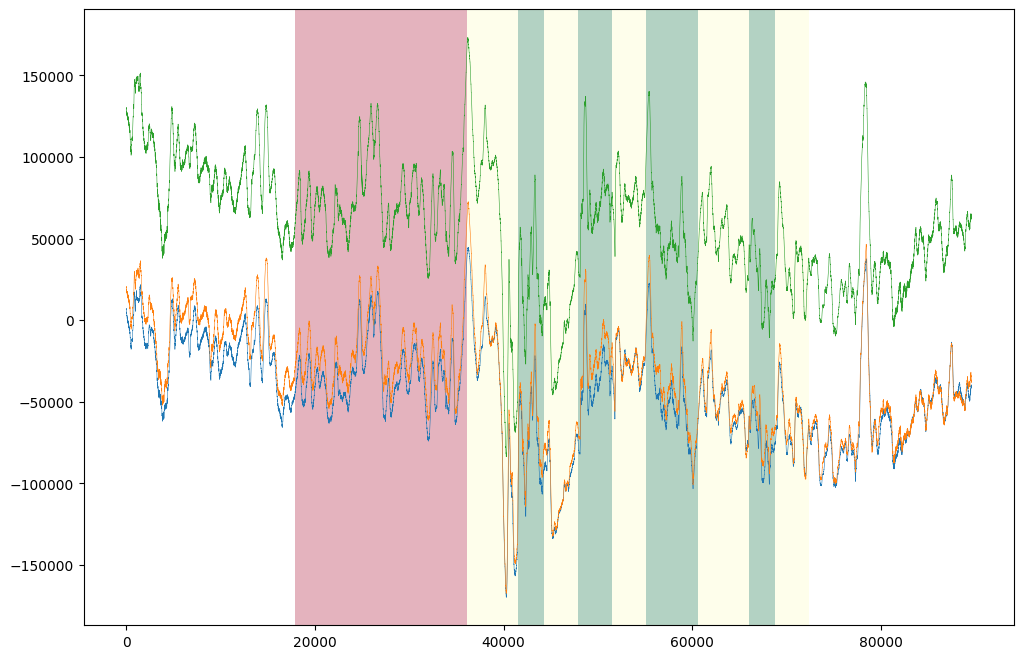

(M)022_20230514_085450_Verity.csv
    id             date protocol  device                      start   
62  22  20230506_090752        H     H10 2023-05-06 09:07:52.406296  \
63  22  20230514_085450        M  Verity 2023-05-14 08:54:50.974385   
64  22  20230514_085450        M  Verity                        NaT   

                          end                  total   
62 2023-05-06 09:14:52.713640 0 days 00:07:00.307344  \
63 2023-05-14 09:16:40.516355 0 days 00:21:49.541970   
64                        NaT                    NaT   

                         avg          fs     t     mast_start_time  
62 0 days 00:00:00.007697372  129.920748  9:05 2023-05-14 09:00:00  
63 0 days 00:00:00.018211859   54.911866  9:05 2023-05-14 09:00:00  
64                       NaT         NaN  9:05 2023-05-14 09:00:00  
전체길이: 71906
시작 시간: 2023-05-14 09:00:00
시작 인덱스 값: 16963
기간 리스트: [Timestamp('2023-05-14 09:00:00'), Timestamp('2023-05-14 09:05:00'), Timestamp('2023-05-14 09:06:30'), Timestamp('202

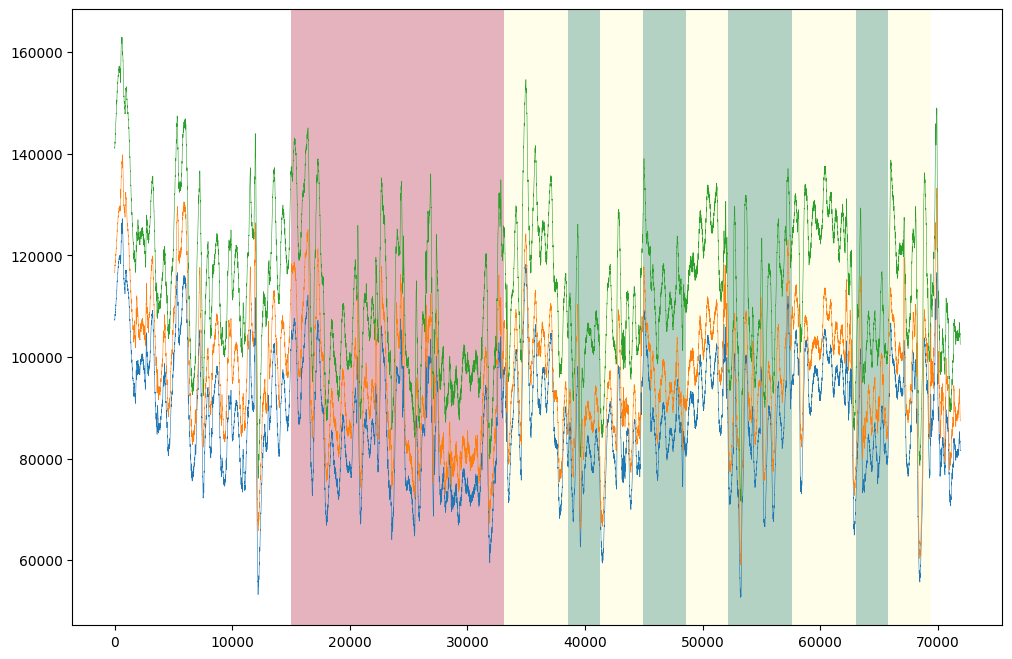

(M)023_20230514_113519_Verity.csv
    id             date protocol  device                      start   
65  23  20230506_091654        H     H10 2023-05-06 09:16:54.864576  \
66  23  20230514_113519        M  Verity 2023-05-14 11:35:19.244497   
67  23  20230514_113519        M  Verity                        NaT   

                          end                  total   
65 2023-05-06 09:23:56.240945 0 days 00:07:01.376369  \
66 2023-05-14 11:49:06.283682 0 days 00:13:47.039185   
67                        NaT                    NaT   

                         avg          fs      t     mast_start_time  
65 0 days 00:00:00.007696372  129.937630  11:35 2023-05-14 11:30:00  
66 0 days 00:00:00.018183079   54.996425  11:35 2023-05-14 11:30:00  
67                       NaT         NaN  11:35 2023-05-14 11:30:00  
전체길이: 45484
시작 시간: 2023-05-14 11:30:00
시작 인덱스 값: 0
기간 리스트: [Timestamp('2023-05-14 11:30:00'), Timestamp('2023-05-14 11:35:00'), Timestamp('2023-05-14 11:36:30'), Timestamp('202

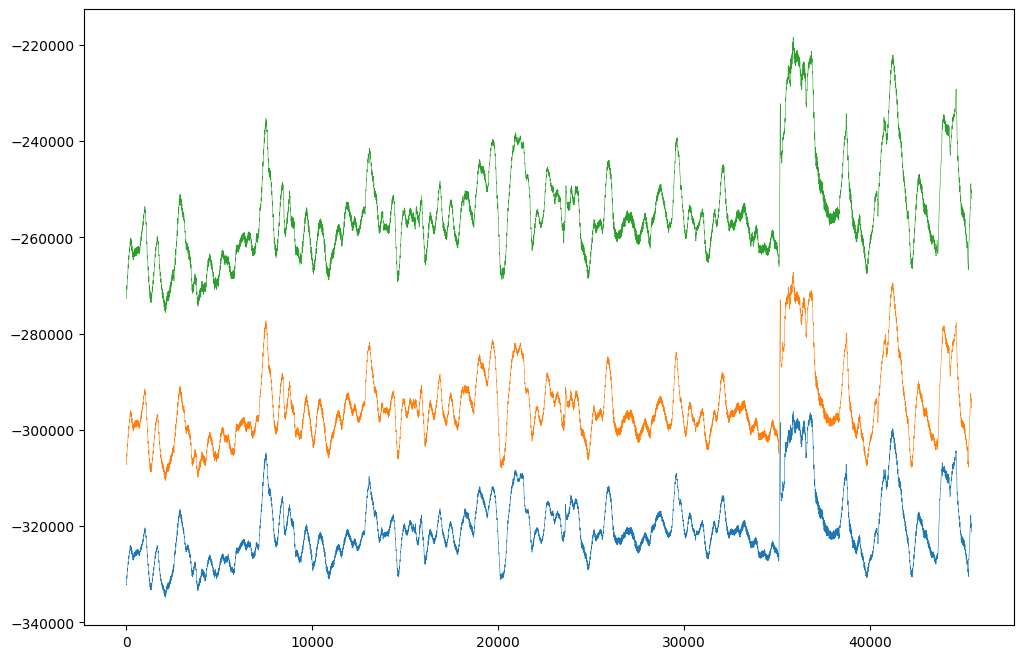

(M)024_20230514_100224_Verity.csv
    id             date protocol  device                      start   
68  24  20230506_101829        H     H10 2023-05-06 10:18:29.229189  \
69  24  20230514_100224        M  Verity 2023-05-14 10:02:24.843199   
70  24  20230514_100224        M  Verity                        NaT   

                          end                  total   
68 2023-05-06 10:25:31.233467 0 days 00:07:02.004278  \
69 2023-05-14 10:24:19.366795 0 days 00:21:54.523596   
70                        NaT                    NaT   

                         avg          fs      t     mast_start_time  
68 0 days 00:00:00.007697577  129.920748  10:11 2023-05-14 10:06:00  
69 0 days 00:00:00.018188308   54.981306  10:11 2023-05-14 10:06:00  
70                       NaT         NaN  10:11 2023-05-14 10:06:00  
전체길이: 72273
시작 시간: 2023-05-14 10:06:00
시작 인덱스 값: 11827
기간 리스트: [Timestamp('2023-05-14 10:06:00'), Timestamp('2023-05-14 10:11:00'), Timestamp('2023-05-14 10:12:30'), Timestamp(

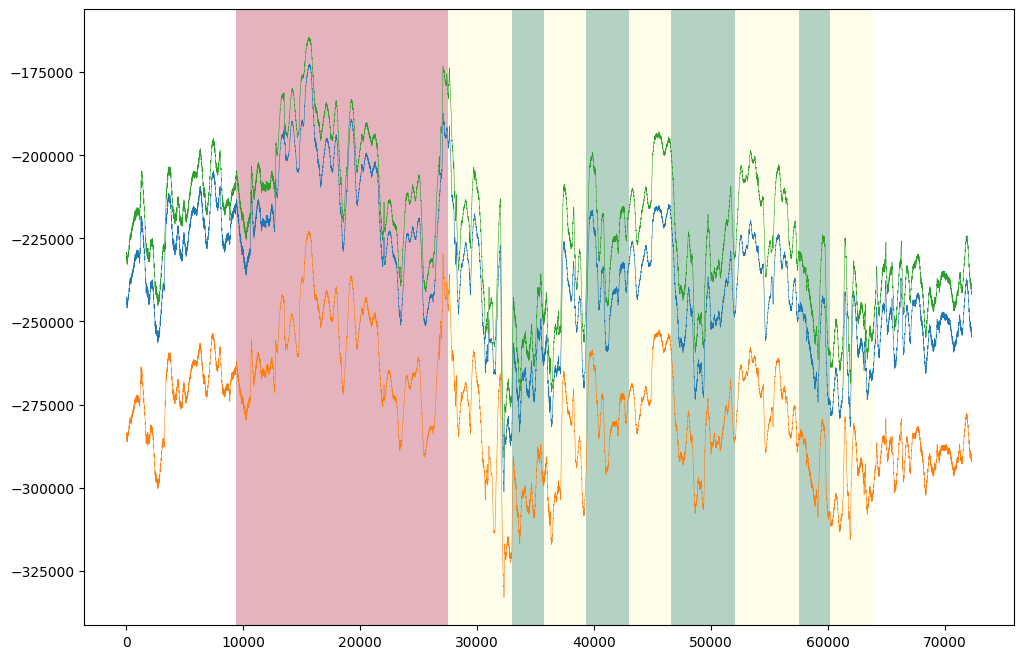

(M)025_20230514_092935_Verity.csv
    id             date protocol  device                      start   
71  25  20230506_105034        H     H10 2023-05-06 10:50:34.435275  \
72  25  20230514_092935        M  Verity 2023-05-14 09:29:35.368145   
73  25  20230514_092935        M  Verity                        NaT   

                          end                  total   
71 2023-05-06 10:57:29.156426 0 days 00:06:54.721151  \
72 2023-05-14 09:54:34.573909 0 days 00:24:59.205764   
73                        NaT                    NaT   

                         avg          fs     t     mast_start_time  
71 0 days 00:00:00.007697983  129.920748  9:40 2023-05-14 09:35:00  
72 0 days 00:00:00.018187181   54.984329  9:40 2023-05-14 09:35:00  
73                       NaT         NaN  9:40 2023-05-14 09:35:00  
전체길이: 82432
시작 시간: 2023-05-14 09:35:00
시작 인덱스 값: 17846
기간 리스트: [Timestamp('2023-05-14 09:35:00'), Timestamp('2023-05-14 09:40:00'), Timestamp('2023-05-14 09:41:30'), Timestamp('202

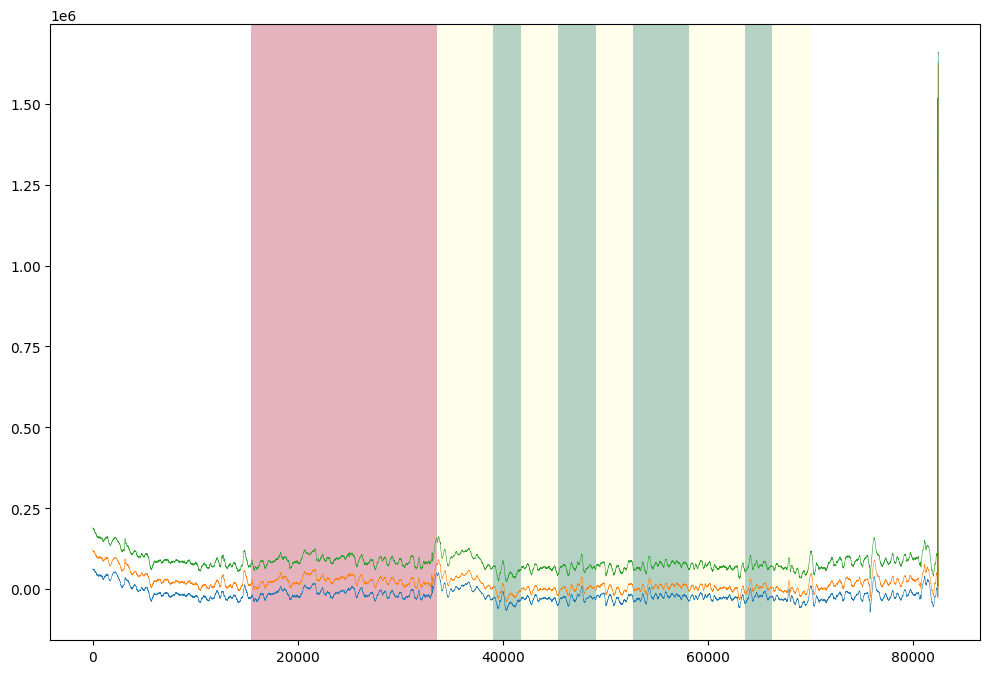

(M)026_20230514_093003_Verity.csv
    id             date protocol  device                      start   
74  26  20230506_100534        H     H10 2023-05-06 10:05:34.470963  \
75  26  20230514_093003        M  Verity 2023-05-14 09:30:03.316107   
76  26  20230514_093003        M  Verity                        NaT   

                          end                  total   
74 2023-05-06 10:12:34.863468 0 days 00:07:00.392505  \
75 2023-05-14 09:58:04.162977 0 days 00:28:00.846870   
76                        NaT                    NaT   

                         avg          fs     t     mast_start_time  
74 0 days 00:00:00.007698932  129.903871  9:40 2023-05-14 09:35:00  
75 0 days 00:00:00.018208916   54.920914  9:40 2023-05-14 09:35:00  
76                       NaT         NaN  9:40 2023-05-14 09:35:00  
전체길이: 92309
시작 시간: 2023-05-14 09:35:00
시작 인덱스 값: 16290
기간 리스트: [Timestamp('2023-05-14 09:35:00'), Timestamp('2023-05-14 09:40:00'), Timestamp('2023-05-14 09:41:30'), Timestamp('202

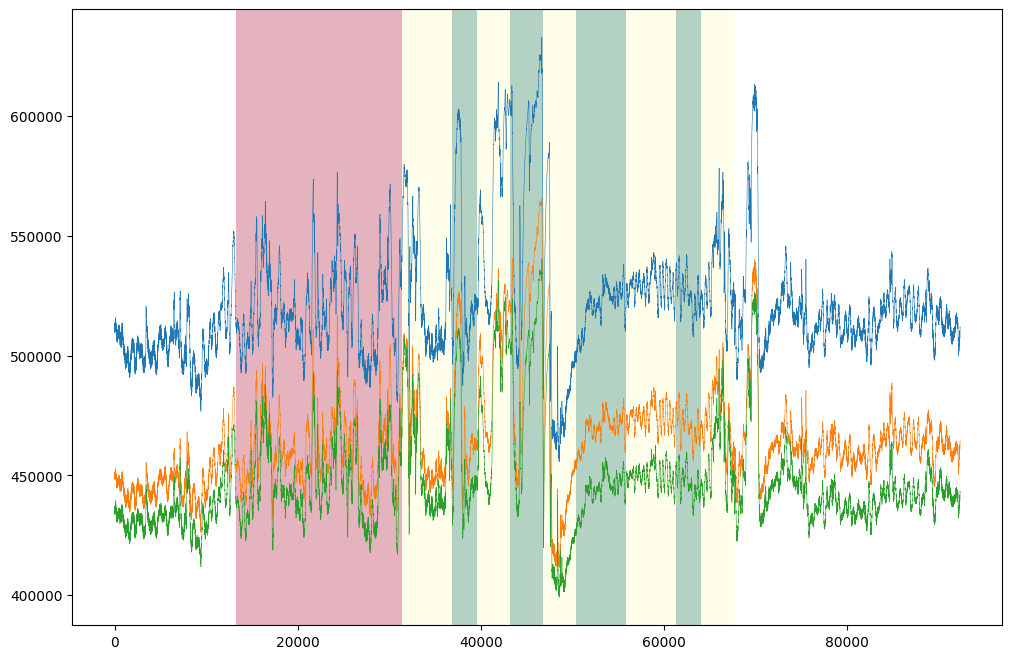

(M)027_20230514_085612_Verity.csv
    id             date protocol  device                      start   
77  27  20230506_103109        H     H10 2023-05-06 10:31:09.073139  \
78  27  20230514_085612        M  Verity 2023-05-14 08:56:12.919930   
79  27  20230514_085612        M  Verity                        NaT   

                          end                  total   
77 2023-05-06 10:38:10.453659 0 days 00:07:01.380520  \
78 2023-05-14 09:21:54.418296 0 days 00:25:41.498366   
79                        NaT                    NaT   

                         avg          fs     t     mast_start_time  
77 0 days 00:00:00.007696447  129.937630  9:07 2023-05-14 09:02:00  
78 0 days 00:00:00.048670698   20.546538  9:07 2023-05-14 09:02:00  
79                       NaT         NaN  9:07 2023-05-14 09:02:00  
전체길이: 31672
시작 시간: 2023-05-14 09:02:00
시작 인덱스 값: 3682
기간 리스트: [Timestamp('2023-05-14 09:02:00'), Timestamp('2023-05-14 09:07:00'), Timestamp('2023-05-14 09:08:30'), Timestamp('2023

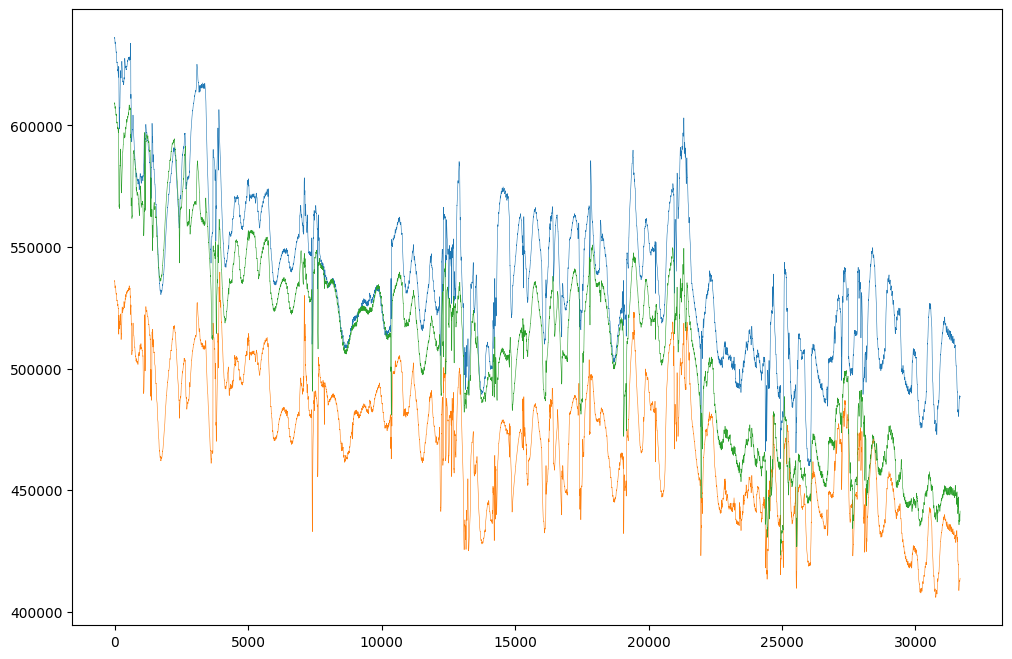

(M)028_20230514_100734_Verity.csv
    id             date protocol  device                      start   
80  28  20230506_103256        H     H10 2023-05-06 10:32:56.768196  \
81  28  20230514_100734        M  Verity 2023-05-14 10:07:34.377399   
82  28  20230514_100734        M  Verity                        NaT   

                          end                  total   
80 2023-05-06 10:39:57.070215 0 days 00:07:00.302019  \
81 2023-05-14 10:24:19.732927 0 days 00:16:45.355528   
82                        NaT                    NaT   

                         avg          fs      t     mast_start_time  
80 0 days 00:00:00.007697275  129.920748  10:14 2023-05-14 10:09:00  
81 0 days 00:00:00.018209333   54.917898  10:14 2023-05-14 10:09:00  
82                       NaT         NaN  10:14 2023-05-14 10:09:00  
전체길이: 55211
시작 시간: 2023-05-14 10:09:00
시작 인덱스 값: 4701
기간 리스트: [Timestamp('2023-05-14 10:09:00'), Timestamp('2023-05-14 10:14:00'), Timestamp('2023-05-14 10:15:30'), Timestamp('

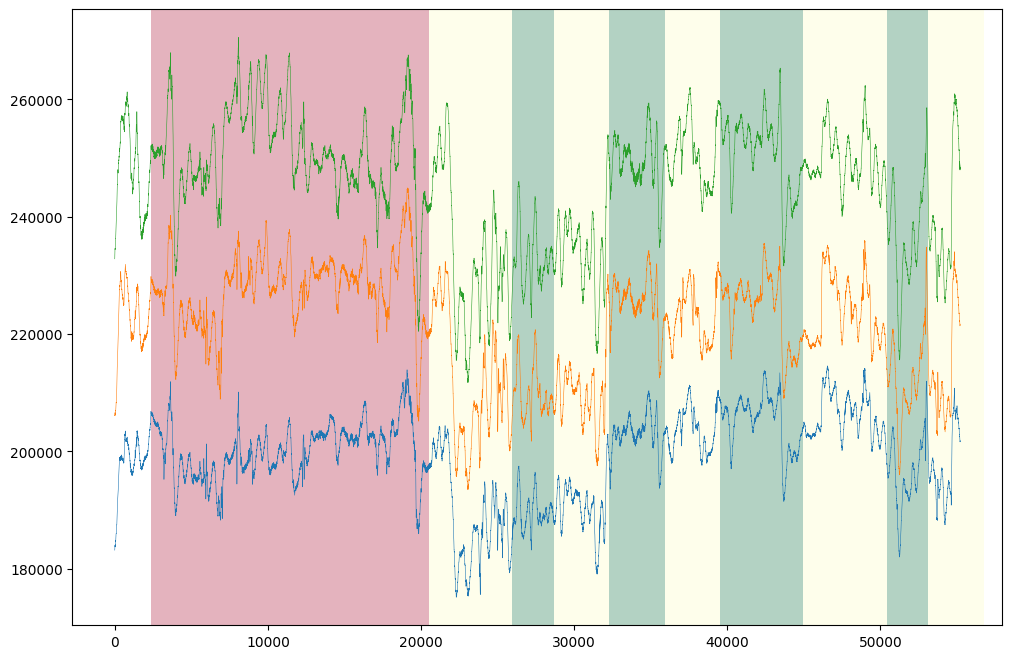

(M)029_20230514_093104_Verity.csv
    id             date protocol  device                      start   
83  29  20230506_110428        H     H10 2023-05-06 11:04:28.957617  \
84  29  20230514_093104        M  Verity 2023-05-14 09:31:04.496008   
85  29  20230514_093104        M  Verity                        NaT   

                          end                  total   
83 2023-05-06 11:11:29.274254 0 days 00:07:00.316637  \
84 2023-05-14 09:51:54.062783 0 days 00:20:49.566775   
85                        NaT                    NaT   

                         avg          fs     t     mast_start_time  
83 0 days 00:00:00.007697542  129.920748  9:41 2023-05-14 09:36:00  
84 0 days 00:00:00.018241850   54.821556  9:41 2023-05-14 09:36:00  
85                       NaT         NaN  9:41 2023-05-14 09:36:00  
전체길이: 68500
시작 시간: 2023-05-14 09:36:00
시작 인덱스 값: 16198
기간 리스트: [Timestamp('2023-05-14 09:36:00'), Timestamp('2023-05-14 09:41:00'), Timestamp('2023-05-14 09:42:30'), Timestamp('202

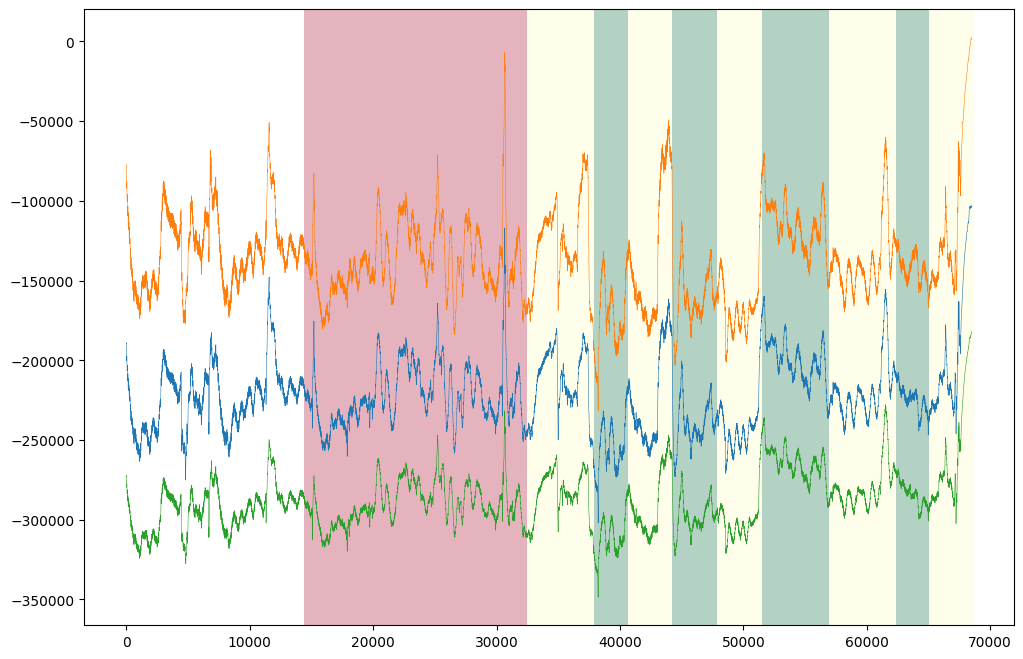

(M)030_20230514_123122_Verity.csv
    id             date protocol  device                      start   
86  30  20230506_111835        H     H10 2023-05-06 11:18:35.099348  \
87  30  20230514_123122        M  Verity 2023-05-14 12:31:22.080433   
88  30  20230514_123122        M  Verity                        NaT   

                          end                  total   
86 2023-05-06 11:25:39.435582 0 days 00:07:04.336234  \
87 2023-05-14 12:54:29.399176 0 days 00:23:07.318743   
88                        NaT                    NaT   

                         avg          fs      t     mast_start_time  
86 0 days 00:00:00.007699106  129.886998  12:41 2023-05-14 12:36:00  
87 0 days 00:00:00.018184327   54.993401  12:41 2023-05-14 12:36:00  
88                       NaT         NaN  12:41 2023-05-14 12:36:00  
전체길이: 76292
시작 시간: 2023-05-14 12:36:00
시작 인덱스 값: 15281
기간 리스트: [Timestamp('2023-05-14 12:36:00'), Timestamp('2023-05-14 12:41:00'), Timestamp('2023-05-14 12:42:30'), Timestamp(

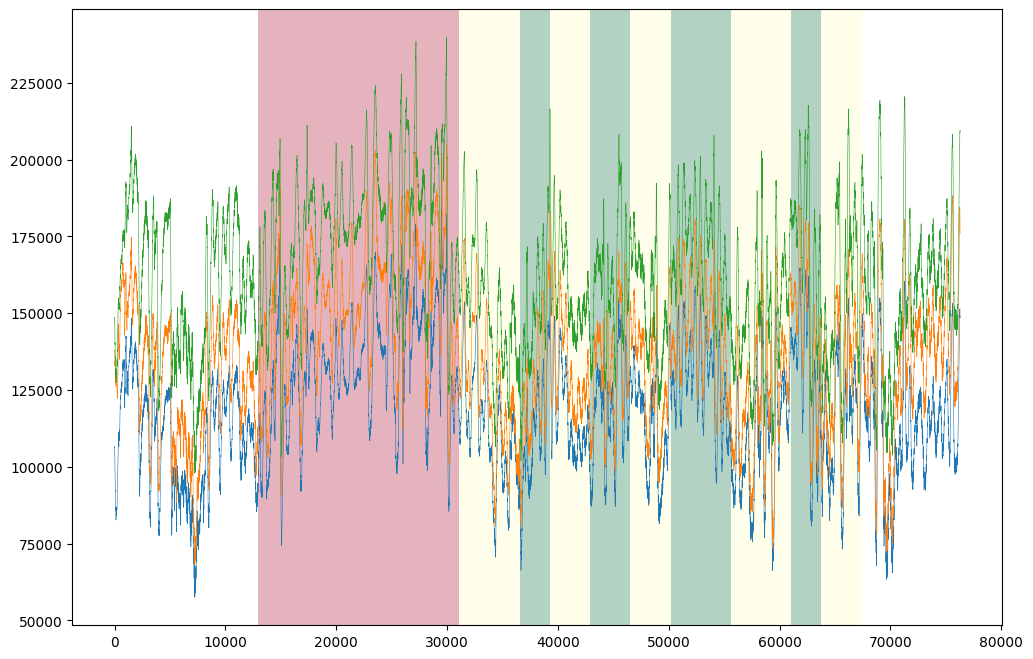

(M)031_20230514_105514_Verity.csv
    id             date protocol  device                      start   
89  31  20230506_115214        H     H10 2023-05-06 11:52:14.626251  \
90  31  20230514_105514        M  Verity 2023-05-14 10:55:14.671939   
91  31  20230514_105514        M  Verity                        NaT   

                          end                  total   
89 2023-05-06 11:59:14.951143 0 days 00:07:00.324892  \
90 2023-05-14 11:19:14.331015 0 days 00:23:59.659076   
91                        NaT                    NaT   

                         avg          fs      t     mast_start_time  
89 0 days 00:00:00.007697694  129.920748  11:05 2023-05-14 11:00:00  
90 0 days 00:00:00.018186009   54.987353  11:05 2023-05-14 11:00:00  
91                       NaT         NaN  11:05 2023-05-14 11:00:00  
전체길이: 79163
시작 시간: 2023-05-14 11:00:00
시작 인덱스 값: 15686
기간 리스트: [Timestamp('2023-05-14 11:00:00'), Timestamp('2023-05-14 11:05:00'), Timestamp('2023-05-14 11:06:30'), Timestamp(

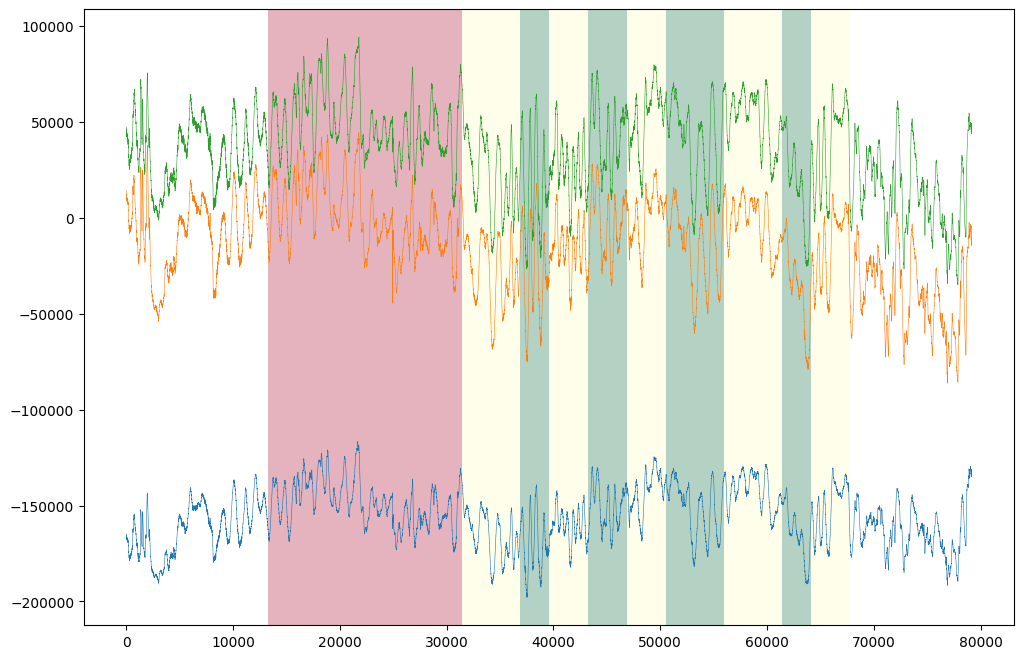

(M)032_20230514_105549_Verity.csv
    id             date protocol  device                      start   
92  32  20230506_110936        H     H10 2023-05-06 11:09:36.766049  \
93  32  20230514_105549        M  Verity 2023-05-14 10:55:49.369581   
94  32  20230514_105549        M  Verity                        NaT   

                          end                  total   
92 2023-05-06 11:16:37.515757 0 days 00:07:00.749708  \
93 2023-05-14 11:16:08.459937 0 days 00:20:19.090356   
94                        NaT                    NaT   

                         avg          fs      t     mast_start_time  
92 0 days 00:00:00.007695186  129.954516  11:05 2023-05-14 11:00:00  
93 0 days 00:00:00.018206791   54.926947  11:05 2023-05-14 11:00:00  
94                       NaT         NaN  11:05 2023-05-14 11:00:00  
전체길이: 66958
시작 시간: 2023-05-14 11:00:00
시작 인덱스 값: 13763
기간 리스트: [Timestamp('2023-05-14 11:00:00'), Timestamp('2023-05-14 11:05:00'), Timestamp('2023-05-14 11:06:30'), Timestamp(

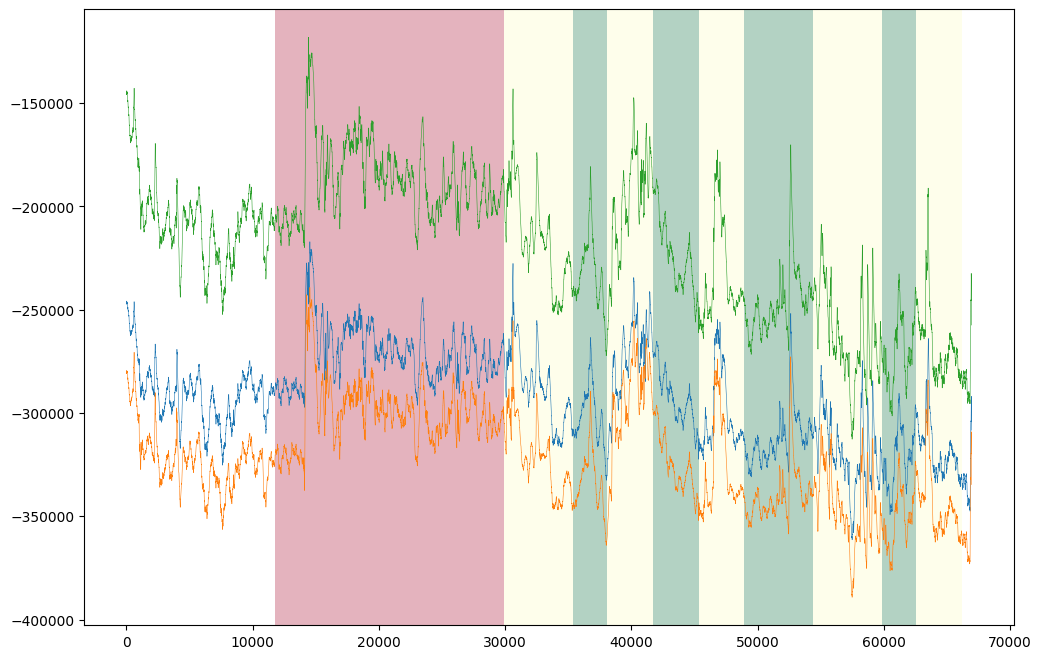

(M)033_20230514_100159_Verity.csv
    id             date protocol  device                      start   
95  33  20230506_113121        H     H10 2023-05-06 11:31:21.331819  \
96  33  20230514_100159        M  Verity 2023-05-14 10:01:59.452482   
97  33  20230514_100159        M  Verity                        NaT   

                          end                  total   
95 2023-05-06 11:38:22.168992 0 days 00:07:00.837173  \
96 2023-05-14 10:23:13.260858 0 days 00:21:13.808376   
97                        NaT                    NaT   

                         avg          fs      t     mast_start_time  
95 0 days 00:00:00.007696786  129.937630  10:12 2023-05-14 10:07:00  
96 0 days 00:00:00.018240257   54.824561  10:12 2023-05-14 10:07:00  
97                       NaT         NaN  10:12 2023-05-14 10:07:00  
전체길이: 69835
시작 시간: 2023-05-14 10:07:00
시작 인덱스 값: 16475
기간 리스트: [Timestamp('2023-05-14 10:07:00'), Timestamp('2023-05-14 10:12:00'), Timestamp('2023-05-14 10:13:30'), Timestamp(

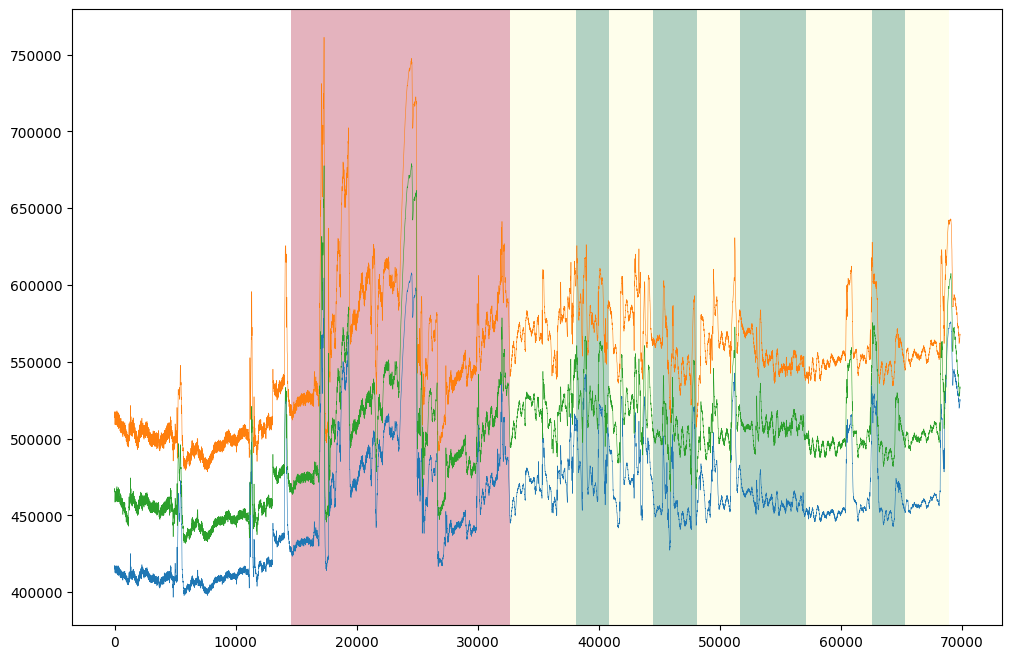

(M)034_20230514_122503_Verity.csv
     id             date protocol  device                      start   
98   34  20230506_113727        H     H10 2023-05-06 11:37:27.072680  \
99   34  20230514_122503        M  Verity 2023-05-14 12:25:03.030555   
100  34  20230514_122503        M  Verity                        NaT   

                           end                  total   
98  2023-05-06 11:44:27.361256 0 days 00:07:00.288576  \
99  2023-05-14 12:45:09.410426 0 days 00:20:06.379871   
100                        NaT                    NaT   

                          avg          fs      t     mast_start_time  
98  0 days 00:00:00.007697029  129.920748  12:35 2023-05-14 12:30:00  
99  0 days 00:00:00.018195774   54.960154  12:35 2023-05-14 12:30:00  
100                       NaT         NaN  12:35 2023-05-14 12:30:00  
전체길이: 66300
시작 시간: 2023-05-14 12:30:00
시작 인덱스 값: 16315
기간 리스트: [Timestamp('2023-05-14 12:30:00'), Timestamp('2023-05-14 12:35:00'), Timestamp('2023-05-14 12:36:30')

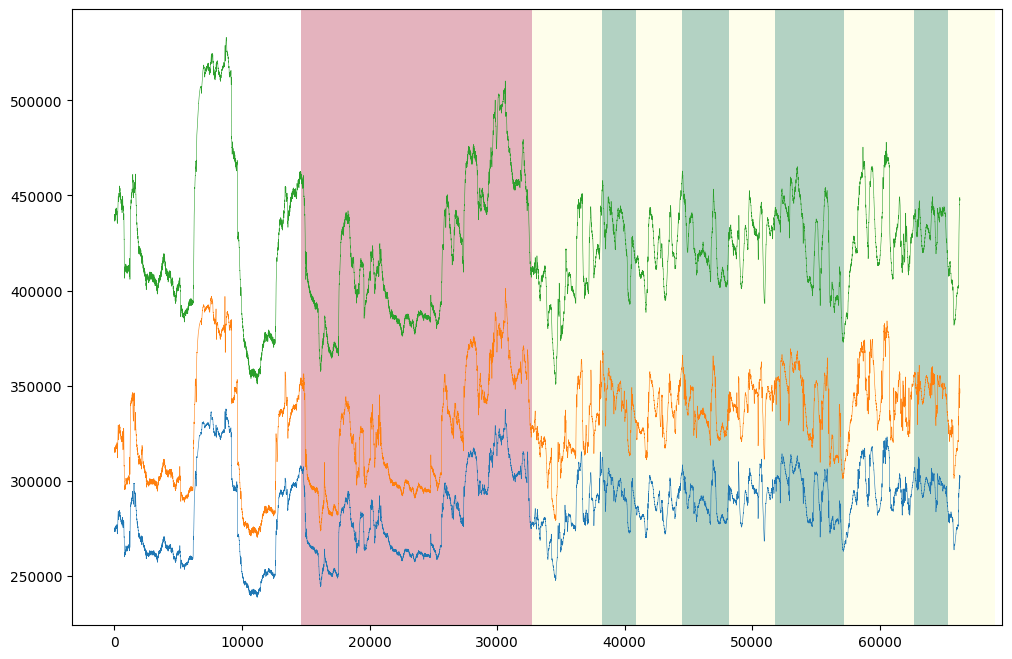

(M)035_20230514_115902_Verity.csv
     id             date protocol  device                      start   
101  35  20230506_120250        H     H10 2023-05-06 12:02:50.029903  \
102  35  20230514_115902        M  Verity 2023-05-14 11:59:02.159787   
103  35  20230514_115902        M  Verity                        NaT   

                           end                  total   
101 2023-05-06 12:09:50.837992 0 days 00:07:00.808089  \
102 2023-05-14 12:20:25.929047 0 days 00:21:23.769260   
103                        NaT                    NaT   

                          avg          fs      t     mast_start_time  
101 0 days 00:00:00.007696254  129.937630  12:05 2023-05-14 12:00:00  
102 0 days 00:00:00.018183185   54.996425  12:05 2023-05-14 12:00:00  
103                       NaT         NaN  12:05 2023-05-14 12:00:00  
전체길이: 70602
시작 시간: 2023-05-14 12:00:00
시작 인덱스 값: 3181
기간 리스트: [Timestamp('2023-05-14 12:00:00'), Timestamp('2023-05-14 12:05:00'), Timestamp('2023-05-14 12:06:30'),

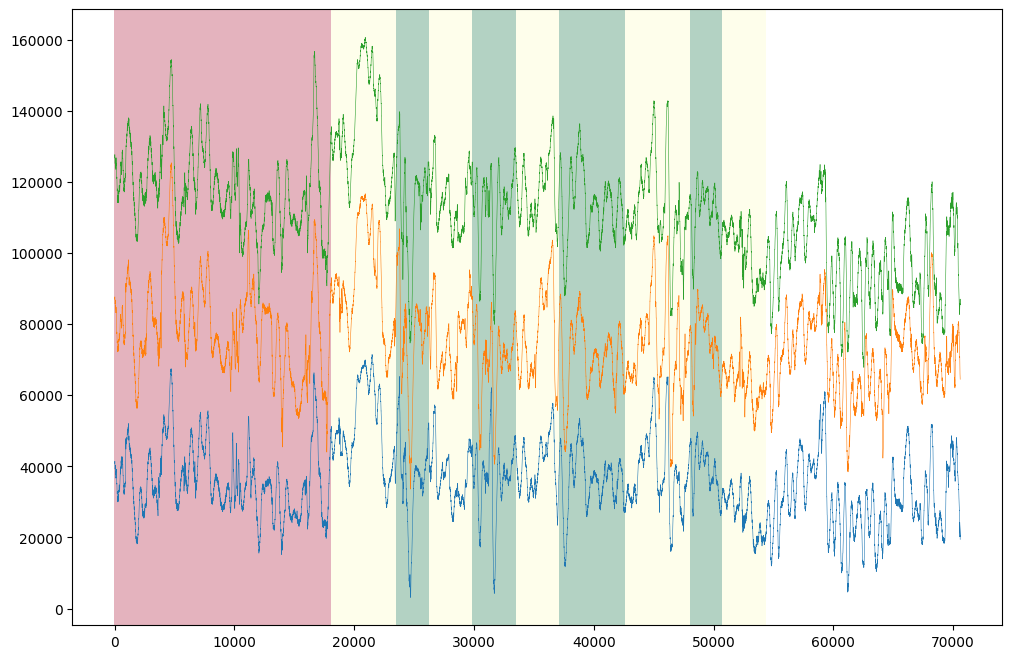

(M)036_20230514_105506_Verity.csv
     id             date protocol  device                      start   
104  36  20230506_125632        H     H10 2023-05-06 12:56:32.414951  \
105  36  20230514_105506        M  Verity 2023-05-14 10:55:06.571445   
106  36  20230514_105506        M  Verity                        NaT   

                           end                  total   
104 2023-05-06 13:03:32.715154 0 days 00:07:00.300203  \
105 2023-05-14 11:17:02.528114 0 days 00:21:55.956669   
106                        NaT                    NaT   

                          avg          fs      t     mast_start_time  
104 0 days 00:00:00.007697242  129.920748  11:05 2023-05-14 11:00:00  
105 0 days 00:00:00.018241200   54.821556  11:05 2023-05-14 11:00:00  
106                       NaT         NaN  11:05 2023-05-14 11:00:00  
전체길이: 72142
시작 시간: 2023-05-14 11:00:00
시작 인덱스 값: 16084
기간 리스트: [Timestamp('2023-05-14 11:00:00'), Timestamp('2023-05-14 11:05:00'), Timestamp('2023-05-14 11:06:30')

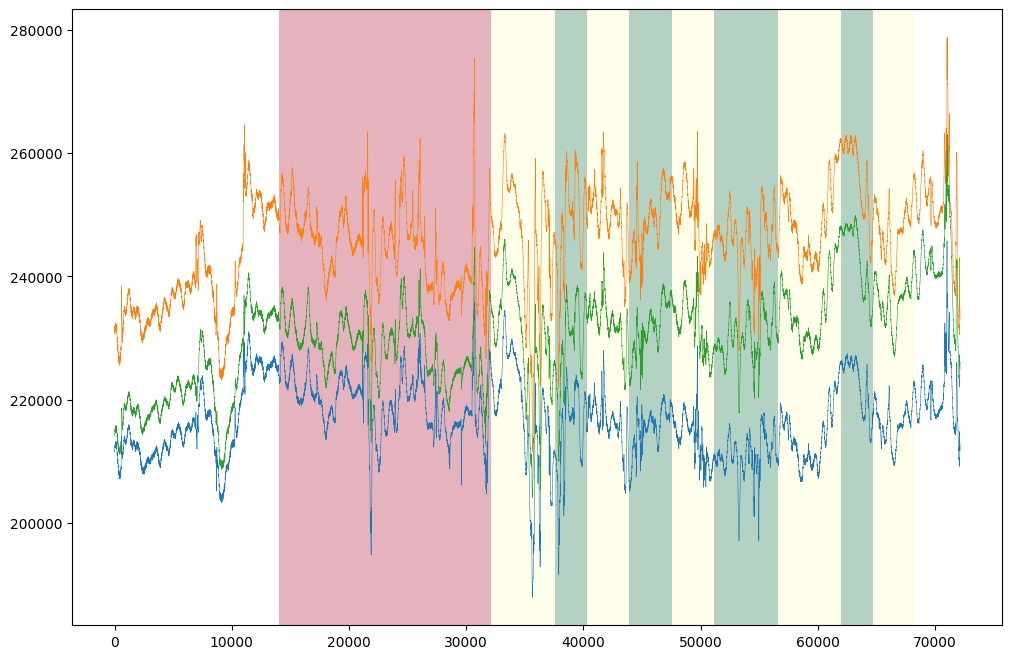

(M)037_20230514_123409_Verity.csv
     id             date protocol  device                      start   
107  37  20230506_123958        H     H10 2023-05-06 12:39:58.315628  \
108  37  20230514_123409        M  Verity 2023-05-14 12:34:10.015124   
109  37  20230514_123409        M  Verity                        NaT   

                           end                  total   
107 2023-05-06 12:46:59.208120 0 days 00:07:00.892492  \
108 2023-05-14 12:53:48.423063 0 days 00:19:38.407939   
109                        NaT                    NaT   

                          avg          fs      t     mast_start_time  
107 0 days 00:00:00.007697797  129.920748  12:43 2023-05-14 12:38:00  
108 0 days 00:00:00.018240761   54.824561  12:43 2023-05-14 12:38:00  
109                       NaT         NaN  12:43 2023-05-14 12:38:00  
전체길이: 64603
시작 시간: 2023-05-14 12:38:00
시작 인덱스 값: 12606
기간 리스트: [Timestamp('2023-05-14 12:38:00'), Timestamp('2023-05-14 12:43:00'), Timestamp('2023-05-14 12:44:30')

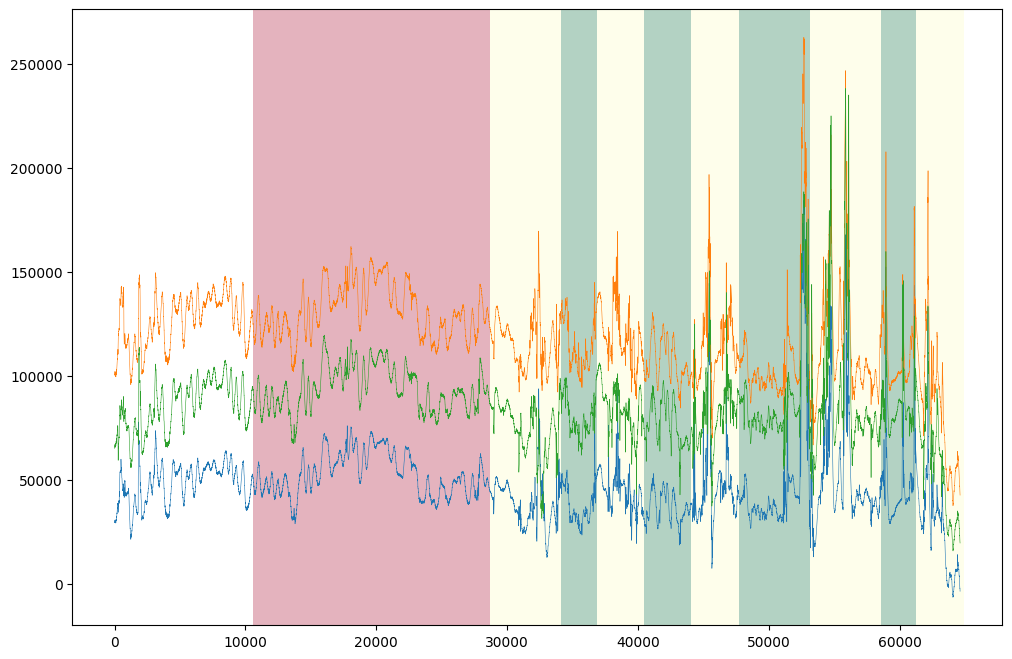

(M)038_20230514_113625_Verity.csv
     id             date protocol  device                      start   
113  38  20230514_113625        M  Verity 2023-05-14 11:36:25.852871  \
114  38  20230514_113625        M  Verity                        NaT   

                           end                  total   
113 2023-05-14 11:56:15.661173 0 days 00:19:49.808302  \
114                        NaT                    NaT   

                          avg        fs      t     mast_start_time  
113 0 days 00:00:00.018207542  54.92393  11:46 2023-05-14 11:41:00  
114                       NaT       NaN  11:46 2023-05-14 11:41:00  
전체길이: 65347
시작 시간: 2023-05-14 11:41:00
시작 인덱스 값: 15052
기간 리스트: [Timestamp('2023-05-14 11:41:00'), Timestamp('2023-05-14 11:46:00'), Timestamp('2023-05-14 11:47:30'), Timestamp('2023-05-14 11:48:15'), Timestamp('2023-05-14 11:49:15'), Timestamp('2023-05-14 11:50:15'), Timestamp('2023-05-14 11:51:15'), Timestamp('2023-05-14 11:52:45'), Timestamp('2023-05-14 11:54:15'), 

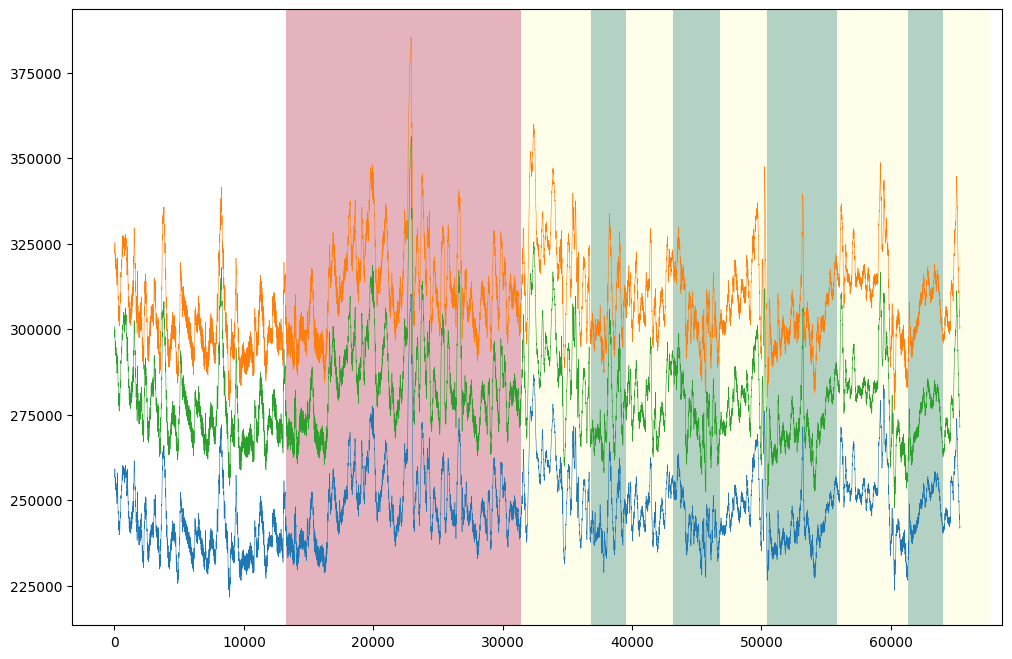

(M)039_20230514_114313_Verity.csv
     id             date protocol  device                      start   
110  39  20230506_122927        H     H10 2023-05-06 12:29:27.980722  \
111  39  20230514_114313        M  Verity 2023-05-14 11:43:13.389437   
112  39  20230514_114313        M  Verity                        NaT   

                           end                  total   
110 2023-05-06 12:36:28.839654 0 days 00:07:00.858932  \
111 2023-05-14 12:00:50.702732 0 days 00:17:37.313295   
112                        NaT                    NaT   

                          avg          fs      t     mast_start_time  
110 0 days 00:00:00.007697184  129.920748  11:50 2023-05-14 11:45:00  
111 0 days 00:00:00.018241490   54.821556  11:50 2023-05-14 11:45:00  
112                       NaT         NaN  11:50 2023-05-14 11:45:00  
전체길이: 57962
시작 시간: 2023-05-14 11:45:00
시작 인덱스 값: 5844
기간 리스트: [Timestamp('2023-05-14 11:45:00'), Timestamp('2023-05-14 11:50:00'), Timestamp('2023-05-14 11:51:30'),

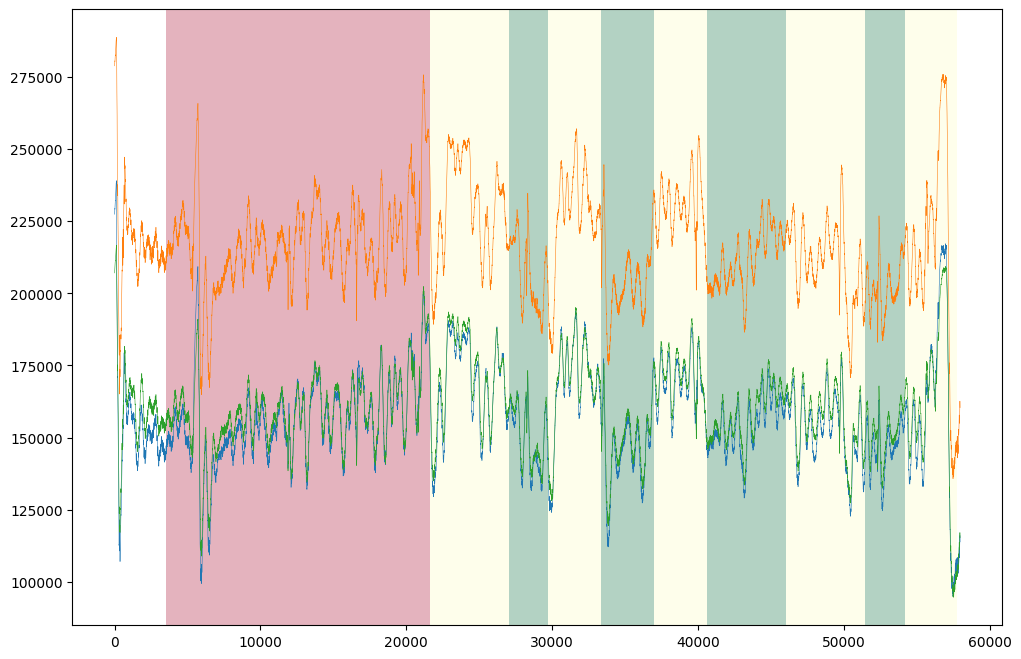

In [36]:
for i in mast_verity_dict:
    
    print(i)
    cid = int(i[3:6])
    # print(mast_verity_dict[i][mast_verity_dict[i]['times'] >= (df[df['id'] == cid].iloc[0]['mast_start_time'])].head())
    
    #start 시간은 마스트 시작 시간 5분 전
    print(df[df['id'] == cid])
    start_time = df[df['id'] == cid].iloc[0]['mast_start_time']

    try:
        start_index = mast_verity_dict[i][mast_verity_dict[i]['times'] >= start_time].min().idx
    except:
        print('unknown error')
        pass
    print('전체길이:',len(mast_verity_dict[i]))
    print('시작 시간:', start_time)
    print('시작 인덱스 값:', start_index)
    
    #시작 시간 init
    period= start_time
    period_ls = [start_time] # [휴식, HIT, N, HIT ...]
    
    #sector init
    period_sector = [start_index] # 마커 리스트
    part_len = [] # 각 파트 길이
    tmp =  start_index # 길이 계산용
    
    
    #MAST_TIME_TABLE에 따라서 설정
    for s in MAST_TIME_TABLE:
        #시작 시간 + 섹션 길이
        period += datetime.timedelta(seconds = s)
        # 기간 리스트에 추가
        period_ls.append(period) 
    print('기간 리스트:',period_ls)

    #기간 리스트에 따라서 길이 계산   
    for j in range(len(period_ls)-1):
        #n-1 ~ n 기간 길이 계산 
        period_length = len(mast_verity_dict[i][mast_verity_dict[i].times.between(period_ls[j], period_ls[j+1]) == True])
        #부분 인덱스 길이 리스트에 추가 
        part_len.append(period_length)

        #전체 인덱스 길이 계산 즉 이게 마커
        tmp += period_length
        #섹터 리스트에 추가 마커 리스트
        period_sector.append(tmp)
    
    print('각 섹터 길이:',part_len)
    print('각 섹터:', period_sector)
    # 프로토콜 번호 지정
    for j in range(len(period_sector)-1):
        if period_sector[j] < period_sector[j+1]:
            mast_verity_dict[i].loc[period_sector[j]+1:period_sector[j+1], 'proc'] = MAST_PROTOCOL[j]
            
        else:
            break

    fig = plt.figure(figsize=(12,8), facecolor='white')
    axes = mast_verity_dict[i]['ppg0'].plot(linewidth = 0.4)
    axes = mast_verity_dict[i]['ppg1'].plot(linewidth = 0.4)
    axes = mast_verity_dict[i]['ppg2'].plot(linewidth = 0.4)
    
    cmap = mpl.colormaps.get_cmap('Set3')
    axes.pcolorfast(axes.get_xlim(), axes.get_ylim(), mast_verity_dict[i]['proc'].values[np.newaxis],
            cmap='RdYlGn', alpha=0.3)
    plt.show()
    

In [37]:
from itertools import groupby

def target_ranges_extraction(lst):
    ranges = []
    for k, g in groupby(enumerate(lst), lambda x: x[1] != 0):
        if k:
            group = list(g)
            start_idx = group[0][0]
            end_idx = group[-1][0]
            ranges.append((start_idx, end_idx))
    return ranges


def draw_ppg(data, sample_rate):
    wd, m = hp.process( data, sample_rate, 
                    high_precision=True, clean_rr=True)
    hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
    hp.plot_poincare(wd, m)
    plt.show()
    for measure in m.keys():
        print('%s: %f' %(measure, m[measure]))
    return

In [176]:
def madr(data, method = ''):
    '''
    Moving Artifact Detect & Remove method
    Condition: no refer/ synthetic refer/ acc refer
    ** on this no refer & synthetic refer
    first, no refer data approach
    1. statistical method
    stage1: auto correlaton 
    stage2: 
    stage3:
    2. variable frequency complex demodulation
    3. DWT

    '''
    import statsmodels.api as sm

    size = 2 ** np.ceil(np.log2(2*len(data) - 1)).astype('int')
    var = np.var(data)
    lenghth = len(data)
    lag = VERITY_FS*3
    # ac 함수1
    # acf = np.correlate(data[1:lag], data[:lag-1], mode='full')
    # acf = acf / var / len(data)
    
    # #ac function 3 [most fast & effective]
    acf = sm.tsa.acf(data, nlags = lag)

    # # ac function 4
    # fft = np.fft.fft(data, size)
    # # Get the power spectrum
    # pwr = np.abs(fft) ** 2
    # # Calculate the autocorrelation from inverse FFT of the power spectrum
    # acf = np.fft.ifft(pwr).real / var / len(data)  
    # # front 3 seconds
    # acf = acf[:lag]

    # print(acf)

    v = [] # velly idx list
    n = [] # peak idx list
    mue = [] # step size list 

    v.append(np.where(acf == acf.min())[0][0]) #v1
    n.append(v[0]+ np.where(acf[v[0]:] == acf[v[0]:].max())[0][0]) #n1
    mue.append(n[0]) 

    print(v,n,mue)
    try:
        for i in range(len(acf)):
            max_range = int(np.ceil(v[i] + mue[i]+ (mue[i]/3)))
            v.append(n[i]+ np.where(acf[n[i]:max_range] == acf[n[i]:max_range].min())[0][0])
            mue.append(v[i+1] - v[i])
            n.append(n[i] + mue[i+1])
            print(v, n, mue)
    except:
        pass
    
    print('plottttttt')
    # plt.plot(acf)
    plt.plot(data[:lag])
    plt.plot(v, [data[data.keys()[0]][i+1] for i in v], 'ro')
    plt.plot(n, [data[data.keys()[0]][i+1] for i in n], 'bx')
    plt.show()

    return acf

(M)021_20230514_085449_Verity.csv
raw 길이: 89608
[18] [38] [38]
[18, 56] [38, 76] [38, 38]
[18, 56, 95] [38, 76, 115] [38, 38, 39]
[18, 56, 95, 135] [38, 76, 115, 155] [38, 38, 39, 40]
[18, 56, 95, 135, 165] [38, 76, 115, 155, 185] [38, 38, 39, 40, 30]
plottttttt


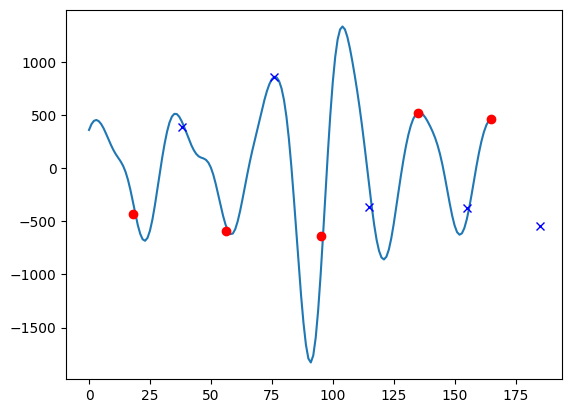

(M)022_20230514_085450_Verity.csv
raw 길이: 71906
[16] [35] [35]
[16, 53] [35, 72] [35, 37]
[16, 53, 87] [35, 72, 106] [35, 37, 34]
[16, 53, 87, 121] [35, 72, 106, 140] [35, 37, 34, 34]
[16, 53, 87, 121, 152] [35, 72, 106, 140, 171] [35, 37, 34, 34, 31]
plottttttt


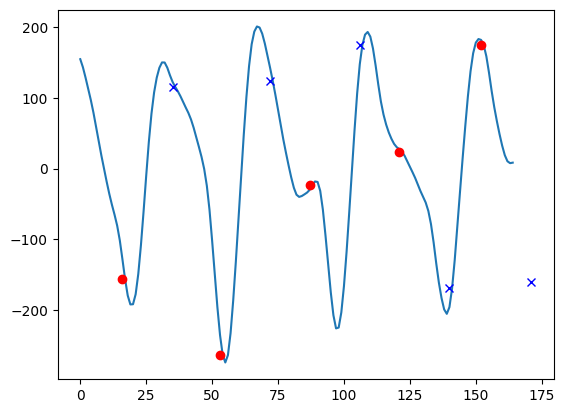

(M)023_20230514_113519_Verity.csv
raw 길이: 45484
[16] [36] [36]
[16, 52] [36, 72] [36, 36]
[16, 52, 88] [36, 72, 108] [36, 36, 36]
[16, 52, 88, 125] [36, 72, 108, 145] [36, 36, 36, 37]
[16, 52, 88, 125, 165] [36, 72, 108, 145, 185] [36, 36, 36, 37, 40]
plottttttt


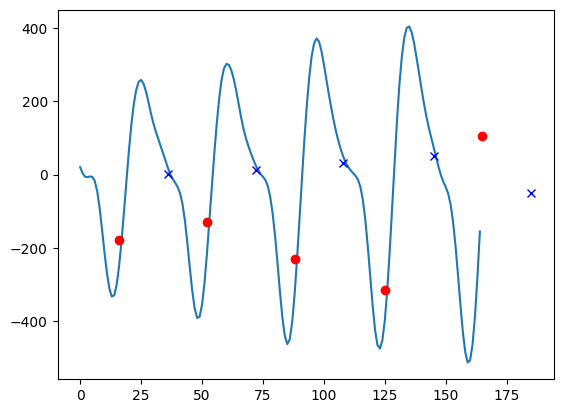

(M)024_20230514_100224_Verity.csv
raw 길이: 72273
[17] [37] [37]
[17, 54] [37, 74] [37, 37]
[17, 54, 92] [37, 74, 112] [37, 37, 38]
[17, 54, 92, 142] [37, 74, 112, 162] [37, 37, 38, 50]
[17, 54, 92, 142, 162] [37, 74, 112, 162, 182] [37, 37, 38, 50, 20]
plottttttt


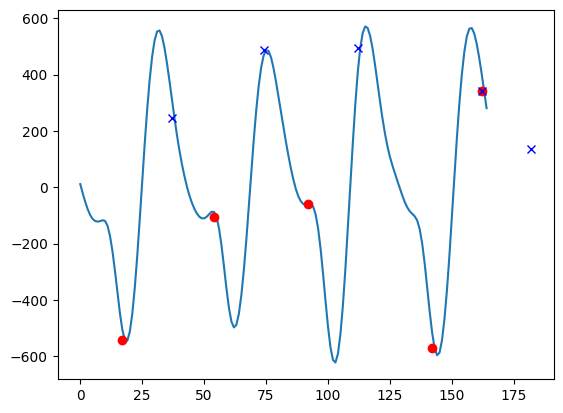

(M)025_20230514_092935_Verity.csv
raw 길이: 82432
[11] [37] [37]
[11, 45] [37, 71] [37, 34]
[11, 45, 90] [37, 71, 116] [37, 34, 45]
[11, 45, 90, 125] [37, 71, 116, 151] [37, 34, 45, 35]
[11, 45, 90, 125, 161] [37, 71, 116, 151, 187] [37, 34, 45, 35, 36]
plottttttt


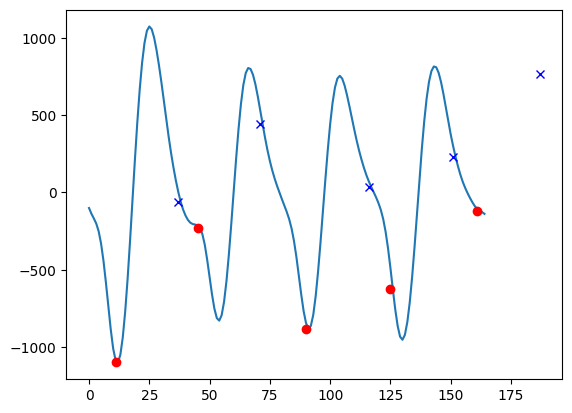

(M)026_20230514_093003_Verity.csv
raw 길이: 92309
[16] [32] [32]
[16, 47] [32, 63] [32, 31]
[16, 47, 79] [32, 63, 95] [32, 31, 32]
[16, 47, 79, 111] [32, 63, 95, 127] [32, 31, 32, 32]
[16, 47, 79, 111, 144] [32, 63, 95, 127, 160] [32, 31, 32, 32, 33]
[16, 47, 79, 111, 144, 165] [32, 63, 95, 127, 160, 181] [32, 31, 32, 32, 33, 21]
plottttttt


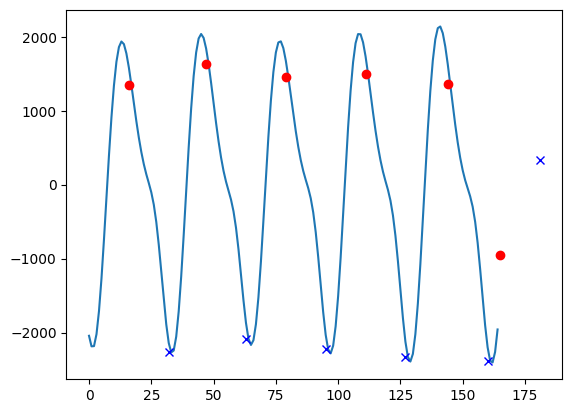

(M)027_20230514_085612_Verity.csv
raw 길이: 31672
[13] [33] [33]
[13, 52] [33, 72] [33, 39]
[13, 52, 91] [33, 72, 111] [33, 39, 39]
[13, 52, 91, 127] [33, 72, 111, 147] [33, 39, 39, 36]
[13, 52, 91, 127, 151] [33, 72, 111, 147, 171] [33, 39, 39, 36, 24]
plottttttt


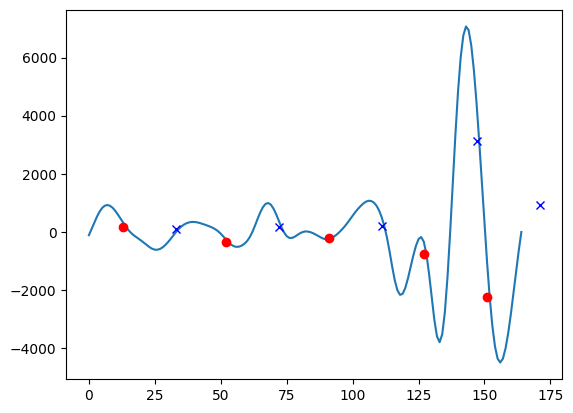

(M)028_20230514_100734_Verity.csv
raw 길이: 55211
[16] [37] [37]
[16, 55] [37, 76] [37, 39]
[16, 55, 95] [37, 76, 116] [37, 39, 40]
[16, 55, 95, 139] [37, 76, 116, 160] [37, 39, 40, 44]
[16, 55, 95, 139, 165] [37, 76, 116, 160, 186] [37, 39, 40, 44, 26]
plottttttt


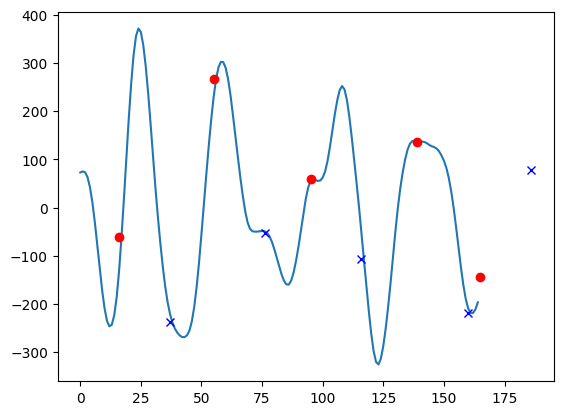

(M)029_20230514_093104_Verity.csv
raw 길이: 68500
[17] [38] [38]
[17, 55] [38, 76] [38, 38]
[17, 55, 94] [38, 76, 115] [38, 38, 39]
[17, 55, 94, 132] [38, 76, 115, 153] [38, 38, 39, 38]
[17, 55, 94, 132, 165] [38, 76, 115, 153, 186] [38, 38, 39, 38, 33]
plottttttt


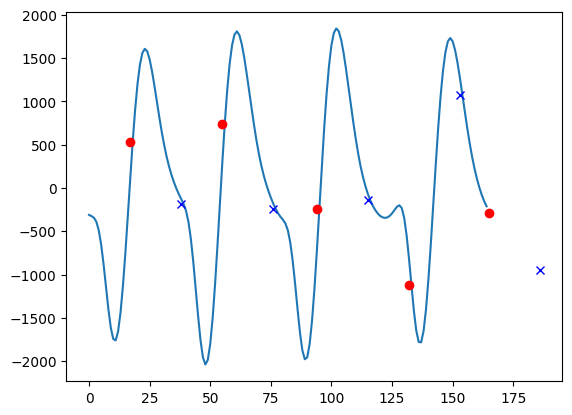

(M)030_20230514_123122_Verity.csv
raw 길이: 76292
[17] [35] [35]
[17, 52] [35, 70] [35, 35]
[17, 52, 86] [35, 70, 104] [35, 35, 34]
[17, 52, 86, 118] [35, 70, 104, 136] [35, 35, 34, 32]
[17, 52, 86, 118, 148] [35, 70, 104, 136, 166] [35, 35, 34, 32, 30]
plottttttt


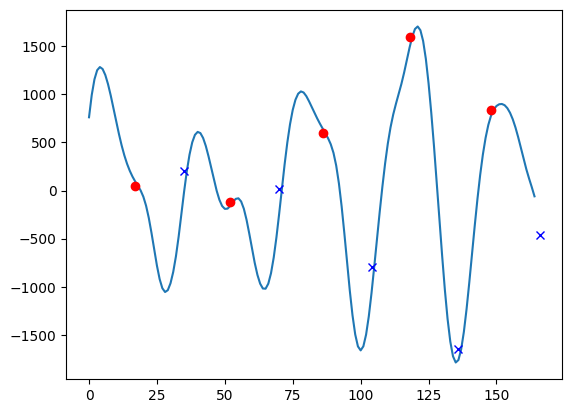

(M)031_20230514_105514_Verity.csv
raw 길이: 79163
[16] [34] [34]
[16, 51] [34, 69] [34, 35]
[16, 51, 85] [34, 69, 103] [34, 35, 34]
[16, 51, 85, 116] [34, 69, 103, 134] [34, 35, 34, 31]
[16, 51, 85, 116, 145] [34, 69, 103, 134, 163] [34, 35, 34, 31, 29]
[16, 51, 85, 116, 145, 165] [34, 69, 103, 134, 163, 183] [34, 35, 34, 31, 29, 20]
plottttttt


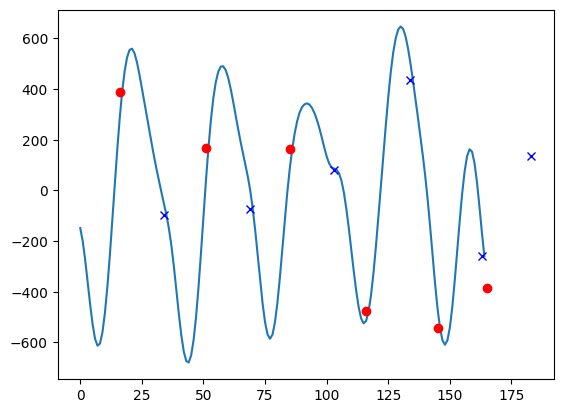

(M)032_20230514_105549_Verity.csv
raw 길이: 66958
[16] [37] [37]
[16, 55] [37, 76] [37, 39]
[16, 55, 95] [37, 76, 116] [37, 39, 40]
[16, 55, 95, 137] [37, 76, 116, 158] [37, 39, 40, 42]
[16, 55, 95, 137, 165] [37, 76, 116, 158, 186] [37, 39, 40, 42, 28]
plottttttt


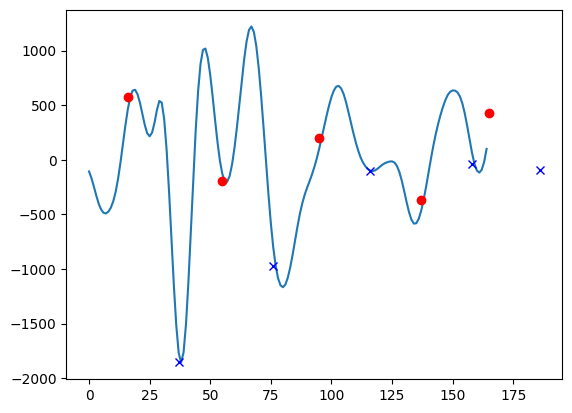

(M)033_20230514_100159_Verity.csv
raw 길이: 69835
[14] [37] [37]
[14, 53] [37, 76] [37, 39]
[14, 53, 98] [37, 76, 121] [37, 39, 45]
[14, 53, 98, 140] [37, 76, 121, 163] [37, 39, 45, 42]
[14, 53, 98, 140, 165] [37, 76, 121, 163, 188] [37, 39, 45, 42, 25]
plottttttt


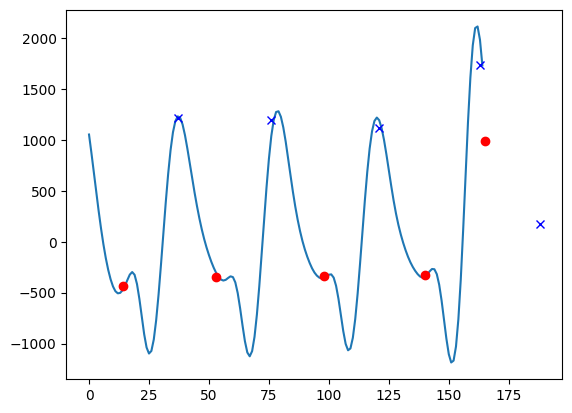

(M)034_20230514_122503_Verity.csv
raw 길이: 66300
[14] [31] [31]
[14, 47] [31, 64] [31, 33]
[14, 47, 78] [31, 64, 95] [31, 33, 31]
[14, 47, 78, 109] [31, 64, 95, 126] [31, 33, 31, 31]
[14, 47, 78, 109, 141] [31, 64, 95, 126, 158] [31, 33, 31, 31, 32]
[14, 47, 78, 109, 141, 165] [31, 64, 95, 126, 158, 182] [31, 33, 31, 31, 32, 24]
plottttttt


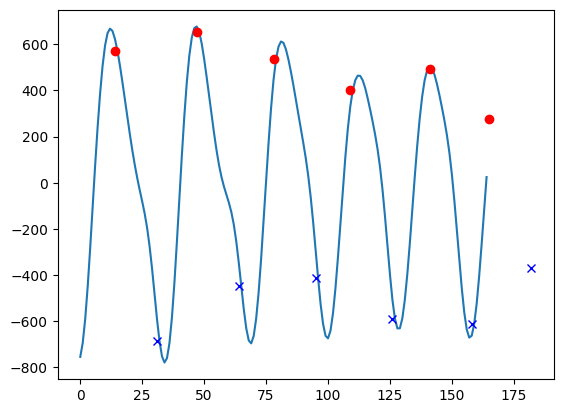

(M)035_20230514_115902_Verity.csv
raw 길이: 70602
[15] [33] [33]
[15, 49] [33, 67] [33, 34]
[15, 49, 83] [33, 67, 101] [33, 34, 34]
[15, 49, 83, 121] [33, 67, 101, 139] [33, 34, 34, 38]
[15, 49, 83, 121, 159] [33, 67, 101, 139, 177] [33, 34, 34, 38, 38]
plottttttt


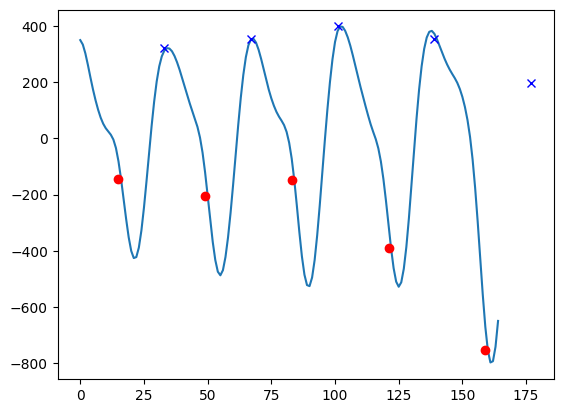

(M)036_20230514_105506_Verity.csv
raw 길이: 72142
[14] [33] [33]
[14, 50] [33, 69] [33, 36]
[14, 50, 83] [33, 69, 102] [33, 36, 33]
[14, 50, 83, 108] [33, 69, 102, 127] [33, 36, 33, 25]
[14, 50, 83, 108, 141] [33, 69, 102, 127, 160] [33, 36, 33, 25, 33]
[14, 50, 83, 108, 141, 165] [33, 69, 102, 127, 160, 184] [33, 36, 33, 25, 33, 24]
plottttttt


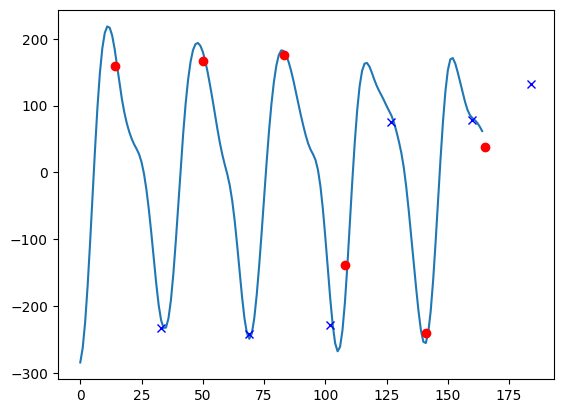

(M)037_20230514_123409_Verity.csv
raw 길이: 64603
[13] [30] [30]
[13, 46] [30, 63] [30, 33]
[13, 46, 89] [30, 63, 106] [30, 33, 43]
[13, 46, 89, 140] [30, 63, 106, 157] [30, 33, 43, 51]
[13, 46, 89, 140, 165] [30, 63, 106, 157, 182] [30, 33, 43, 51, 25]
plottttttt


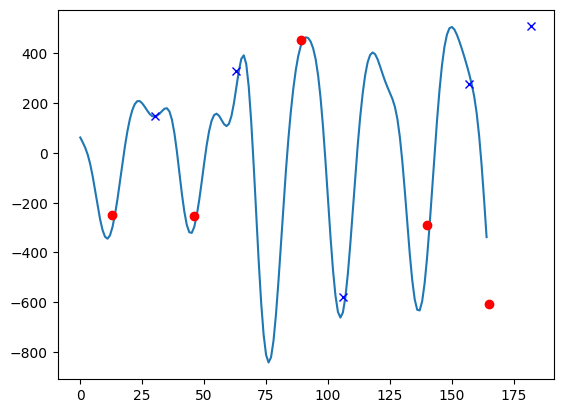

(M)038_20230514_113625_Verity.csv
raw 길이: 65347
[16] [44] [44]
[16, 62] [44, 90] [44, 46]
[16, 62, 112] [44, 90, 140] [44, 46, 50]
[16, 62, 112, 157] [44, 90, 140, 185] [44, 46, 50, 45]
plottttttt


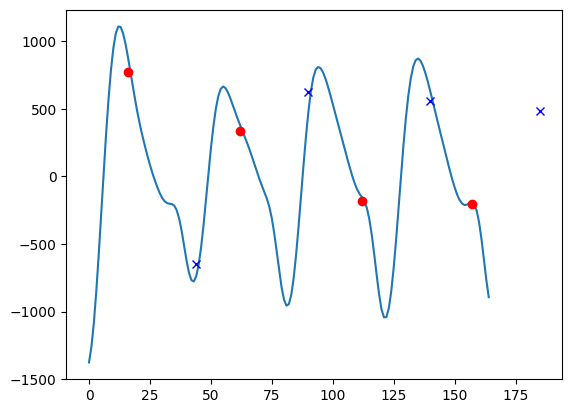

(M)039_20230514_114313_Verity.csv
raw 길이: 57962
[15] [39] [39]
[15, 57] [39, 81] [39, 42]
[15, 57, 104] [39, 81, 128] [39, 42, 47]
[15, 57, 104, 154] [39, 81, 128, 178] [39, 42, 47, 50]
plottttttt


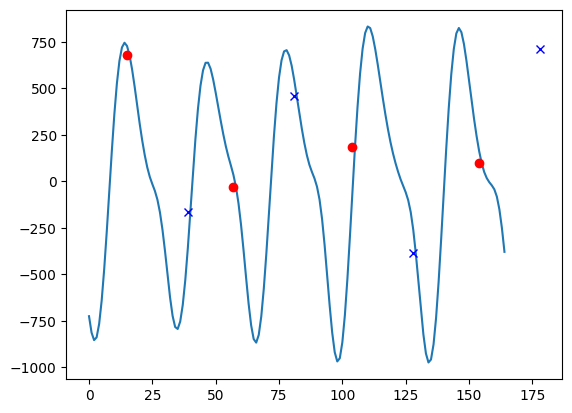

In [177]:
from statsmodels.graphics.tsaplots import plot_acf
for i in mast_verity_dict:
    print(i)
    print('raw 길이:', len(mast_verity_dict[i]))
    
    mast_verity_dict[i]['signal_0'] = mast_verity_dict[i]['ppg0'] - mast_verity_dict[i]['ambient']
    
    mast_verity_dict[i]['signal_0_ffty'] = signal.detrend(mast_verity_dict[i]['ppg0'])
    mast_verity_dict[i]['signal_0_filtered_signal'] = signal.sosfilt(sos, mast_verity_dict[i]['signal_0_ffty'])
    mast_verity_dict[i]['signal_0_filtered_hp']  = hp.filter_signal(mast_verity_dict[i]['signal_0_ffty'], [1.5, 6], sample_rate=VERITY_FS, order=2, filtertype='bandpass')
 
    target = mast_verity_dict[i]['signal_0_filtered_signal'][1000:].reset_index().drop('index', axis = 1)
    # pd.plotting.lag_plot(target)
    # plot_acf(target)
    mar_data = madr(target)


    # fig, axs = plt.subplots(6)
    # fig.tight_layout()
    # plt.figure(figsize=(15, 10), dpi=80)
    
    # axs[0].set_title('Raw')
    # axs[0].plot(mast_verity_dict[i]['ppg0'])

    # axs[1].set_title('detrend')
    # axs[1].plot(mast_verity_dict[i]['signal_0_ffty'])
    
    # axs[2].set_title('detrend + butterworth')
    # axs[2].plot(mast_verity_dict[i]['signal_0_filtered_signal'])

    # axs[3].set_title('detrend + butterworth')
    # axs[3].plot(mast_verity_dict[i]['signal_0_filtered_signal'][1000:2000]) 

    # axs[4].set_title('hp_bandpass filters')
    # axs[4].plot(mast_verity_dict[i]['signal_0_filtered_hp']) 

    # axs[5].set_title('hp_bandpass filters')
    # axs[5].plot(mast_verity_dict[i]['signal_0_filtered_hp'][1000:2000]) 

    # plt.show()


## 윈도우 사이즈에 따라서 분할

    # target_mast = mast_verity_dict[i][mast_verity_dict[i]['proc'].notna()]
    # time_window = 1024
    
    # for p in target_mast['proc'].unique():
    #     print('MAST 프로토콜:',p, MAST_PROTOCOL_NAME[p])
    #     task_data = mast_verity_dict[i][mast_verity_dict[i]['proc'] == p]
        
    #     if len(task_data) > time_window:
    #         splited_target_data = np.array_split(task_data, len(task_data) // time_window)
    #     else:
    #         break
        
    #     print('xxxxxxxx',len(splited_target_data))
    #     for df in splited_target_data:
    #         target = df.reset_index(drop=True).signal_0_filtered1
            
    #         print('-'*30)
                        
    #        draw_ppg(target, VERITY_FS)


## 지정 범위에 따라서 분할

    # resampled = resample( mast_verity_dict[i]['signal_0_filtered_signal'], len( mast_verity_dict[i]['signal_0_filtered_signal']) * 10)
    #don't forget to compute the new sampling rate
    # new_sample_rate = VERITY_FS * 10

    # draw_ppg(mast_verity_dict[i]['signal_0_filtered_signal'], VERITY_FS)

    # for s in [[0, 1000], [1000, 2000], [2000, 3000], [3000, 4000], [4000, 5000]]:
        # draw_ppg(filtered_signal_0[s[0]:s[1]], VERITY_FS) 

In [40]:
sample_rate = VERITY_FS
# motion artifact detection ad reduction in ppg signals based on statistics analysis(2023)
band_pass_filter_pass_band = [0.5, 0.6]

for i in mast_verity_dict:
    print(i)
    print('인덱스 길이:',len(mast_verity_dict[i]))
    
    print(mast_verity_dict[i].keys())


    signal_0 = mast_verity_dict[i]['ppg0']
    # signal_1 = mast_verity_dict[i]['ppg1']
    # signal_2 = mast_verity_dict[i]['ppg2']
    
    # enhanced_signal_0 = hp.enhance_peaks(signal_0, iterations=2)
    # enhanced_signal_1 = hp.enhance_peaks(signal_1, iterations=2)
    # enhanced_signal_2 = hp.enhance_peaks(signal_2, iterations=2)

    # signal_0 = outlier_drop(signal_0)

    filtered_signal_0 = hp.filter_signal(signal_0, band_pass_filter_pass_band, sample_rate=VERITY_FS, 
                                         order=2, filtertype='bandpass')
    # filtered_signal_1 = hp.filter_signal(signal_1, band_pass_filter_pass_band, sample_rate=VERITY_FS, 
    #                                      order=2, filtertype='bandpass')
    # filtered_signal_2 = hp.filter_signal(signal_2, band_pass_filter_pass_band, sample_rate=VERITY_FS, 
    #                                      order=2, filtertype='bandpass')

    


    # plt.plot(filtered_signal_0)
    # plt.show()

    # resampled = resample(filtered_signal_0, len(filtered_signal_0) * 10)

    # #don't forget to compute the new sampling rate
    # new_sample_rate = sample_rate * 10
    # wd, m = hp.process(filtered_signal_0, sample_rate = sample_rate, 
    #                 high_precision=True, clean_rr=True)
    # hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
    # hp.plot_poincare(wd, m)
    # plt.show()
    # for measure in m.keys():
    #     print('%s: %f' %(measure, m[measure]))
    # # for s in [[0, 1000], [1000, 2000], [2000, 3000], [3000, 4000], [4000, 5000]]:
    #     wd, m = hp.process(filtered_signal_0[s[0]:s[1]], sample_rate = sample_rate, 
    #                        high_precision=True, clean_rr=True)
    #     hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
    #     hp.plot_poincare(wd, m)
    #     plt.show()
    #     for measure in m.keys():
    #         print('%s: %f' %(measure, m[measure]))

(M)021_20230514_085449_Verity.csv
인덱스 길이: 89608
Index(['time', 'idx', 'ppg0', 'ppg1', 'ppg2', 'ambient', 'marker', 'proc',
       'times', 'interval', 'signal_0', 'signal_0_ffty', 'signal_0_filtered1'],
      dtype='object')
(M)022_20230514_085450_Verity.csv
인덱스 길이: 71906
Index(['time', 'idx', 'ppg0', 'ppg1', 'ppg2', 'ambient', 'marker', 'proc',
       'times', 'interval', 'signal_0', 'signal_0_ffty', 'signal_0_filtered1'],
      dtype='object')
(M)023_20230514_113519_Verity.csv
인덱스 길이: 45484
Index(['time', 'idx', 'ppg0', 'ppg1', 'ppg2', 'ambient', 'marker', 'proc',
       'times', 'interval', 'signal_0', 'signal_0_ffty', 'signal_0_filtered1'],
      dtype='object')
(M)024_20230514_100224_Verity.csv
인덱스 길이: 72273
Index(['time', 'idx', 'ppg0', 'ppg1', 'ppg2', 'ambient', 'marker', 'proc',
       'times', 'interval', 'signal_0', 'signal_0_ffty', 'signal_0_filtered1'],
      dtype='object')
(M)025_20230514_092935_Verity.csv
인덱스 길이: 82432
Index(['time', 'idx', 'ppg0', 'ppg1', 'ppg2', 'ambie